In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import calendar
from datetime import datetime, timedelta
import gc
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
initial_vars = set(locals().keys())
print(initial_vars)

{'In', '_dh', '__name__', 'Out', 'sns', '_oh', 'exit', 'get_ipython', 'os', '__builtin__', '_i1', '_i2', '__session__', '_', 'plt', 'open', '_iii', 'warnings', '__', 'calendar', '___', '_i', '_ih', '__spec__', 'datetime', '__builtins__', 'pd', 'gc', '__package__', '__doc__', 'np', '__loader__', 'timedelta', 'quit', '_ii'}


In [ ]:
# Path to the file
lsu_file_path = 'exampleData/lsunit_wb_day.txt'
channel_data_path = 'exampleData/channel_sdmorph_day.txt'

In [4]:
def process_large_file(lsu_file_path, lsu_id, chunksize=500000):
    filtered_data = []

    with open(lsu_file_path, 'r') as file:
        header = None  # Placeholder for column names
        chunk = []
        
        for i, line in enumerate(file):
            # Split the line into columns
            line_data = line.split()
            
            # Handle the header (assuming it's in the first 2 rows)
            if i == 1:
                header = line_data
                continue
            
            if i > 2:  # Skip first 3 rows as in your original code
                chunk.append(line_data)
            
            # Process the chunk when it reaches the chunksize
            if len(chunk) == chunksize:
                chunk_df = pd.DataFrame(chunk, columns=header)
                filtered_chunk = chunk_df[chunk_df['name'] == lsu_id]
                filtered_data.append(filtered_chunk)
                chunk = []  # Reset the chunk
        
        # Process the remaining lines in the last chunk
        if chunk:
            chunk_df = pd.DataFrame(chunk, columns=header)
            filtered_chunk = chunk_df[chunk_df['name'] == lsu_id]
            filtered_data.append(filtered_chunk)
    
    # Combine all filtered chunks into a single DataFrame
    filtered_df = pd.concat(filtered_data, ignore_index=True)
    return filtered_df

**Iterate through lsu-channel pair**

In [ ]:
# Accept counter as an input parameter
# Set a default value 0
counter = globals().get('counter', 0)

# List of LSU and Channel IDs
# Add LSU numbers formatted to 3 digits
lsu_numbers = ['121',
#,...add more as needed
]
# Add corresponding channel numbers formatted to 2 digits
channel_numbers = ['12',
#,...add more as needed
]

# Initialize the counter if it is not already set
if 'counter' not in globals():
    counter = 0

# Update the LSU and Channel pair
def get_next_pair():
    global counter
    if counter < len(lsu_numbers):
        lsu_id = f"rtu{lsu_numbers[counter]}"
        channel_id = f"cha{channel_numbers[counter]}"
        counter += 1
        return lsu_id, channel_id
    else:
        return None, None  # No more pairs to process

# Fetch the current LSU/Channel pair
lsu_id, channel_id = get_next_pair()

# Print the current pair (for verification)
print(f"Current LSU ID: {lsu_id}, Channel ID: {channel_id}")


Current LSU ID: rtu132, Channel ID: cha13


**Define the variable to analyze. Adjust if rolling average.**

In [6]:
lsu_var_to_analyze = 'precip_roll_5d'
cha_var_to_analyze = 'flo_out_mm_5d'  #'flo_out_mm'

**Read channel and lsu data**

In [7]:
data_channel = pd.read_csv(
    channel_data_path, 
    sep=r'\s+',  # This regular expression handles multiple spaces/tabs as separators
    skiprows=1    # Skip the first row if it's just column names
)
# Remove any leading/trailing spaces in column names
data_channel.columns = data_channel.columns.str.strip()
data_channel.drop(0, inplace=True)
filtered_postp_channel_data = data_channel[['jday','mon','day','yr','gis_id','name','flo_out_mm']]
channel_data = filtered_postp_channel_data[filtered_postp_channel_data['name']==channel_id]
cols=['yr','mon','day']
channel_data['date'] = channel_data[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
channel_data['date'] = pd.to_datetime(channel_data['date'], format='%Y-%m-%d')
channel_data['flo_out_mm_5d'] = channel_data['flo_out_mm'].rolling(window=5).mean()
#channel_data = channel_data.iloc[:8962,:] #in the future this may not be necessary
channel_data.reset_index(drop=True, inplace=True)
channel_data

,jday,mon,day,yr,gis_id,name,flo_out_mm,date,flo_out_mm_5d
0,1,1,1,1983,13,cha13,0.000000,1983-01-01,NaN
1,2,1,2,1983,13,cha13,0.000877,1983-01-02,NaN
2,3,1,3,1983,13,cha13,0.002429,1983-01-03,NaN
3,4,1,4,1983,13,cha13,0.004005,1983-01-04,NaN
4,5,1,5,1983,13,cha13,0.005817,1983-01-05,0.002626
...,...,...,...,...,...,...,...,...,...
12414,362,12,27,2016,13,cha13,0.052890,2016-12-27,0.057468
12415,363,12,28,2016,13,cha13,0.050370,2016-12-28,0.055066
12416,364,12,29,2016,13,cha13,0.048570,2016-12-29,0.052824
12417,365,12,30,2016,13,cha13,0.046460,2016-12-30,0.050698


In [8]:
postp_data = process_large_file(lsu_file_path, lsu_id)
filtered_postp_data = postp_data[['jday','yr','mon','day','name','precip','et','sw_final','sw_300','surq_cha']]
lsu_data = filtered_postp_data[filtered_postp_data.name== lsu_id]
cols=["yr","mon","day"]
lsu_data['date'] = lsu_data[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
lsu_data['date'] = pd.to_datetime(lsu_data['date'], format='%Y-%m-%d')
lsu_data = lsu_data.apply(lambda col: pd.to_numeric(col, errors='coerce') if col.name != 'date' else col)
lsu_data['precip_roll_10d'] = lsu_data['precip'].rolling(window=10).mean()
lsu_data['precip_roll_5d'] = lsu_data['precip'].rolling(window=5).mean()
lsu_data['surq_cha_roll_10d'] = lsu_data['surq_cha'].rolling(window=10).mean()
lsu_data.reset_index(drop=True, inplace=True)

In [9]:
def calculate_standalone_events(precip_events, streamflow_events, aligned_df, 
                               buffer_days=3, max_lag_days=10):
    """
    Calculate standalone precipitation (P) and streamflow (Q) events with buffer tolerance.
    
    Parameters:
    - precip_events (DataFrame): DataFrame of precipitation events
    - streamflow_events (DataFrame): DataFrame of streamflow events
    - aligned_df (DataFrame): DataFrame of aligned P and Q events
    - buffer_days (int): Number of days of leniency for considering events related
    - max_lag_days (int): Maximum days between events beyond which they're considered unrelated
    
    Returns:
    - standalone_p (DataFrame): DataFrame of standalone P events
    - standalone_q (DataFrame): DataFrame of standalone Q events
    """
    from datetime import timedelta
    
    # Create lists of start and end dates from aligned P events
    aligned_p_start_dates = aligned_df['start_date_precip']
    aligned_p_end_dates = aligned_df['end_date_precip']
    
    # Identify P events that do not have overlapping or similar start/end dates with any aligned P events
    standalone_p = precip_events[
        ~precip_events['start_date_precip'].apply(
            lambda x: any(
                # Allow buffer days before and after the aligned range
                (x >= (start_date - timedelta(days=buffer_days)) and 
                 x <= (end_date + timedelta(days=buffer_days)))
                for start_date, end_date in zip(aligned_p_start_dates, aligned_p_end_dates)
            )
        )
    ]
    
    # Similarly for Q events
    aligned_q_start_dates = aligned_df['start_date_streamflow']
    aligned_q_end_dates = aligned_df['end_date_streamflow']
    
    standalone_q = streamflow_events[
        ~streamflow_events['start_date_streamflow'].apply(
            lambda x: any(
                (x >= (start_date - timedelta(days=buffer_days)) and 
                 x <= (end_date + timedelta(days=buffer_days)))
                for start_date, end_date in zip(aligned_q_start_dates, aligned_q_end_dates)
            )
        )
    ]
    
    # Optional: Check for "too distant" relationships in the aligned_df
    # This would flag potentially incorrect alignments
    too_distant_alignments = aligned_df[
        (aligned_df['start_date_streamflow'] - aligned_df['end_date_precip']).dt.days > max_lag_days
    ]
    
    if len(too_distant_alignments) > 0:
        print(f"Warning: {len(too_distant_alignments)} aligned events exceed maximum lag of {max_lag_days} days")
    
    return standalone_p, standalone_q

def pool_dependent_droughts(df, tmin=2):
    # Sort by start date to maintain chronological order
    df = df.sort_values(by='start_date').reset_index()

    df['dbt'] = df['num_days']  # Start with drought duration
    df['pooled'] = 0  # Initially, assume no pooling
    
    # Iterate over the rows and pool dependent droughts
    for i in range(1, len(df)):
        # Calculate the gap between consecutive droughts
        gap = (df.loc[i, 'start_date'] - df.loc[i-1, 'end_date']).days
        
        if gap <= tmin:
            # Pool the current drought with the previous one
            df.loc[i, 'pooled'] = df.loc[i-1, 'pooled'] + 1 if df.loc[i-1, 'pooled'] > 0 else 2  # Count the pooled events
            df.loc[i, 'dbt'] = df.loc[i, 'num_days'] + df.loc[i-1, 'dbt']  # Sum durations - this will be the new duration column
            df.loc[i, 'sum_y_values'] += df.loc[i-1, 'sum_y_values']  # Sum deficit volumes
            
            # Update the start date to reflect the start of the pooled event
            df.loc[i, 'start_date'] = df.loc[i-1, 'start_date']
            
            # Set the previous row's pooled column to NaN to avoid double-counting
            df.loc[i-1, 'pooled'] = None
    
    df = df.dropna(subset=['pooled']).reset_index()
    
    # pooled is 0 where no pooling occurred
    df['pooled'] = df['pooled'].fillna(0).astype(int)
    
    return df


def aggregate_p_events_within_q(precip_events, q_event):
    """Enhanced function with relationship type classification"""
    # Find P events within Q event or within 3 days prior
    within_q_or_close = precip_events[
        ((precip_events['start_date_precip'] >= q_event['start_date_streamflow'] - pd.Timedelta(days=3)) &
         (precip_events['end_date_precip'] <= q_event['end_date_streamflow'])) |
        ((precip_events['end_date_precip'] >= q_event['start_date_streamflow'] - pd.Timedelta(days=3)) &
         (precip_events['end_date_precip'] < q_event['start_date_streamflow']))
    ]

    if within_q_or_close.empty:
        return None  # No P events for this Q event

    # Classify each P event's relationship type
    relationship_types = []
    for _, p_event in within_q_or_close.iterrows():
        # Initiating relationship: P event ends before or very close to Q start
        if p_event['end_date_precip'] <= q_event['start_date_streamflow'] + pd.Timedelta(days=1):
            relationship_types.append('initiating')
        # Sustaining relationship: P event overlaps significantly with Q event
        elif (p_event['start_date_precip'] < q_event['end_date_streamflow']) and \
             (p_event['end_date_precip'] > q_event['start_date_streamflow'] + pd.Timedelta(days=1)):
            relationship_types.append('sustaining')
        else:
            relationship_types.append('uncertain')
    
    # Add relationship type count information
    aggregated_p = {
        'start_date_precip': within_q_or_close['start_date_precip'].min(),
        'end_date_precip': within_q_or_close['end_date_precip'].max(),
        'sum_y_values_precip': within_q_or_close['sum_y_values_precip'].sum(),
        'dbt_pp_precip': within_q_or_close['dbt_pp_precip'].sum(),
        'p_events_count': len(within_q_or_close),
        'initiating_count': relationship_types.count('initiating'),
        'sustaining_count': relationship_types.count('sustaining'),
        'is_complex': len(within_q_or_close) > 1  # Flag for complex events
    }
    
    return aggregated_p

In [ ]:
def identify_drought_relationships(precip_events, q_event, max_initial_lag=60, max_gap_after_p=10, overlap_buffer=10, leniency_period=3):
    """
    Identifies both initiating and sustaining precipitation drought events for a streamflow drought.
    
    Parameters:
    - precip_events: DataFrame containing precipitation drought events
    - q_event: A single streamflow drought event
    - max_initial_lag: Maximum days between P drought start and Q drought start
    - max_gap_after_p: Maximum days allowed between P drought end and Q drought start
    - overlap_buffer: Days of flexibility for considering overlapping events
    - leniency_period: Days of leniency for P events starting shortly after Q event (to be considered initiating)
    
    Returns:
    - Dictionary containing initiating and sustaining P events
    """
    # Convert dates to datetime 
    q_start = pd.to_datetime(q_event['start_date_streamflow'])
    q_end = pd.to_datetime(q_event['end_date_streamflow'])
    
    # Find initiating P events with refined constraints AND include leniency period
    initiating_p_events = precip_events[
        # P starts before Q start OR within leniency period after Q start
        (
            (pd.to_datetime(precip_events['start_date_precip']) <= q_start + pd.Timedelta(days=leniency_period)) & 
            # Maintain the constraint that P must start within max_initial_lag days before Q start
            (pd.to_datetime(precip_events['start_date_precip']) >= q_start - pd.Timedelta(days=max_initial_lag))
        ) &
        # Gap between P end and Q start is reasonable
        (pd.to_datetime(precip_events['end_date_precip']) >= q_start - pd.Timedelta(days=max_gap_after_p))
    ]
    
    # Find sustaining P events (those that overlap with Q event)
    sustaining_p_events = precip_events[
        # P event must have some actual temporal overlap with Q event
        ((pd.to_datetime(precip_events['start_date_precip']) <= q_end) &
         (pd.to_datetime(precip_events['end_date_precip']) >= q_start))
    ]
    
    # Select the most relevant initiating event (closest to Q start)
    initiating_p = None
    if not initiating_p_events.empty:
        # Find the P event with start date closest to Q start date
        initiating_index = (pd.to_datetime(initiating_p_events['start_date_precip']) - q_start).abs().idxmin()
        initiating_p = initiating_p_events.loc[initiating_index].to_dict()
        initiating_p['relationship_type'] = 'initiating'
        
        # Calculate lag between P start and Q start
        p_start = pd.to_datetime(initiating_p_events.loc[initiating_index, 'start_date_precip'])
        initiating_p['lag'] = max(0,(q_start - p_start).days)
        
        # Calculate gap between P end and Q start
        p_end = pd.to_datetime(initiating_p_events.loc[initiating_index, 'end_date_precip'])
        initiating_p['gap_after_p'] = (q_start - p_end).days
        
        # Set overlap fields to NaN for initiating events
        initiating_p['overlap_days'] = np.nan
        initiating_p['overlap_ratio'] = np.nan
    
    # Process sustaining events - now only include those that don't qualify as "initiating" with leniency
    sustaining_relationships = []
    for idx, p_event in sustaining_p_events.iterrows():
        # Skip if this is the same as the initiating event
        if initiating_p and p_event['start_date_precip'] == initiating_p['start_date_precip']:
            continue
            
        p_start = pd.to_datetime(p_event['start_date_precip'])
        p_end = pd.to_datetime(p_event['end_date_precip'])
        
        # Skip events that would qualify as initiating with leniency but weren't selected as the best initiating candidate
        if p_start <= q_start + pd.Timedelta(days=leniency_period) and p_start >= q_start - pd.Timedelta(days=max_initial_lag):
            if not initiating_p:  # Should not happen but just to be safe
                continue
        
        # Calculate actual temporal overlap
        overlap_start = max(p_start, q_start)
        overlap_end = min(p_end, q_end)
        
        # Only include if there's actual overlap
        if overlap_start <= overlap_end:
            overlap_days = (overlap_end - overlap_start).days + 1
            
            # Only include relationships with positive overlap
            if overlap_days > 0:
                relationship = p_event.to_dict()
                relationship['relationship_type'] = 'sustaining'
                relationship['overlap_days'] = overlap_days
                relationship['overlap_ratio'] = overlap_days / q_event['dbt_pp_streamflow']
                
                # Set lag and gap to NaN for sustaining events
                relationship['lag'] = np.nan
                relationship['gap_after_p'] = np.nan
                
                sustaining_relationships.append(relationship)
    
    return {
        'initiating': initiating_p,
        'sustaining': sustaining_relationships
    }

**Calculate threshold and customize if needed. Plot threshold with raw time series and shade deficit.**

Running analysis for LSU ID: rtu132, Channel ID: cha13
Analyzing precipitation deficits...
Identified 101 significant precipitation deficit events


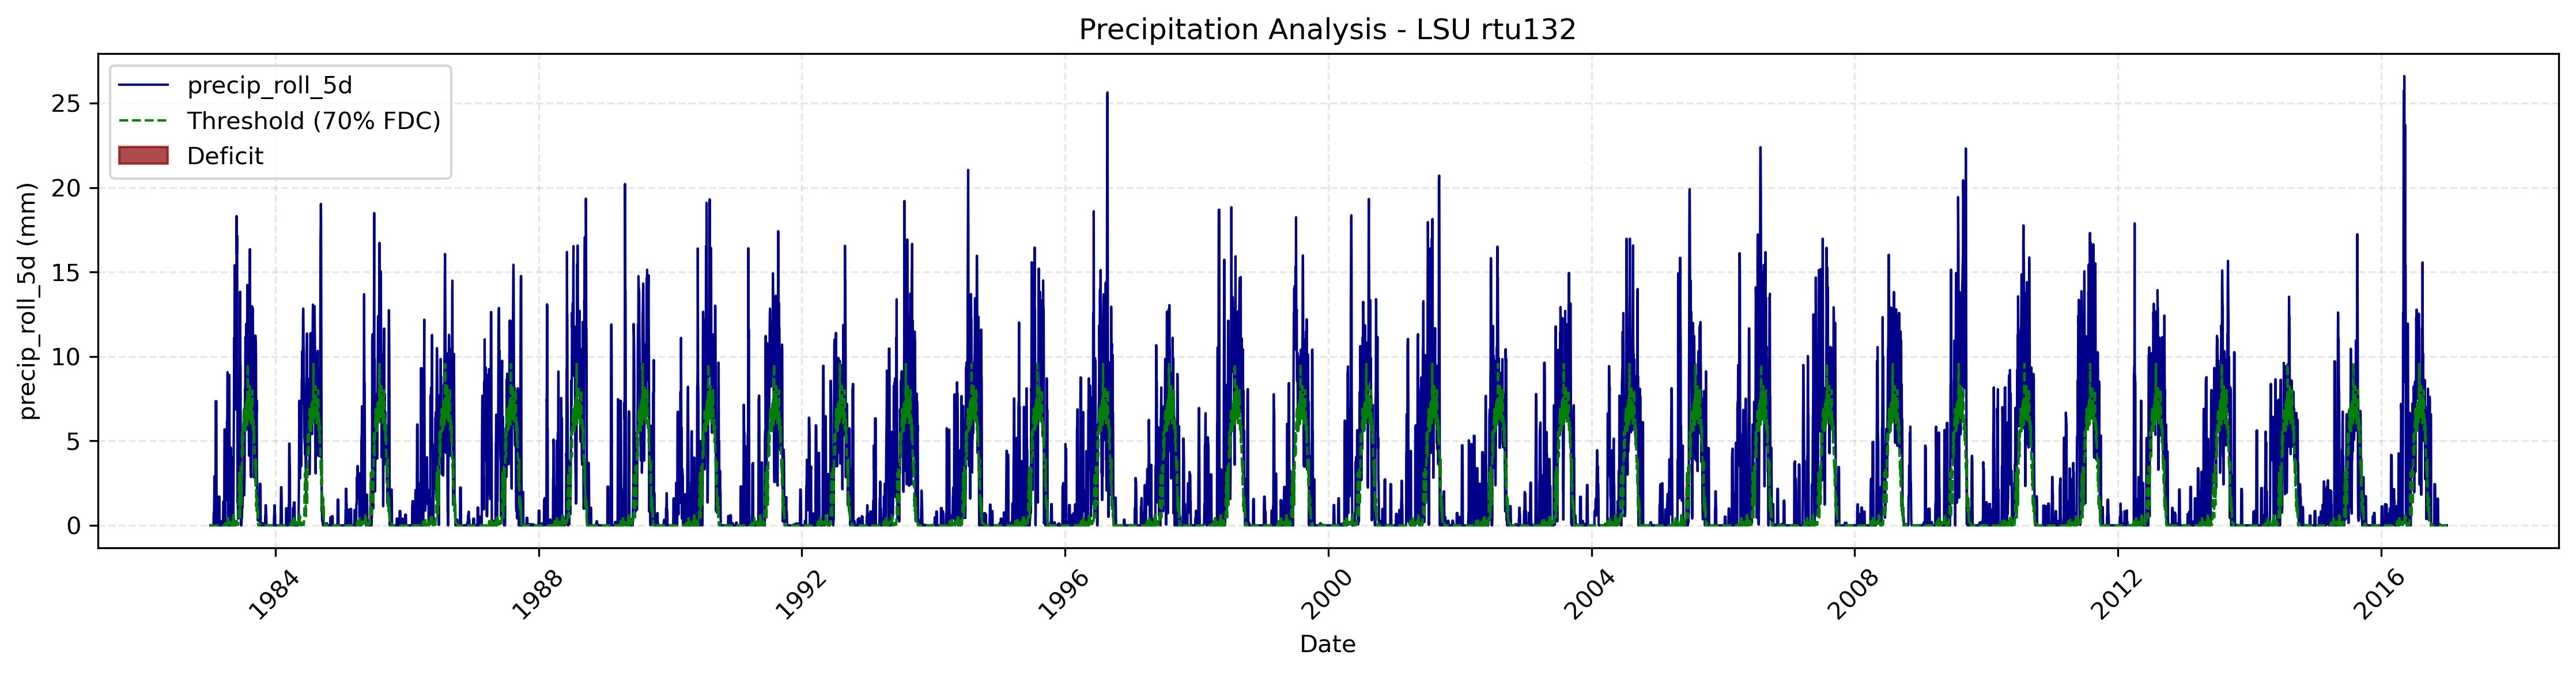


Analyzing streamflow deficits...
Identified 14 significant streamflow deficit events


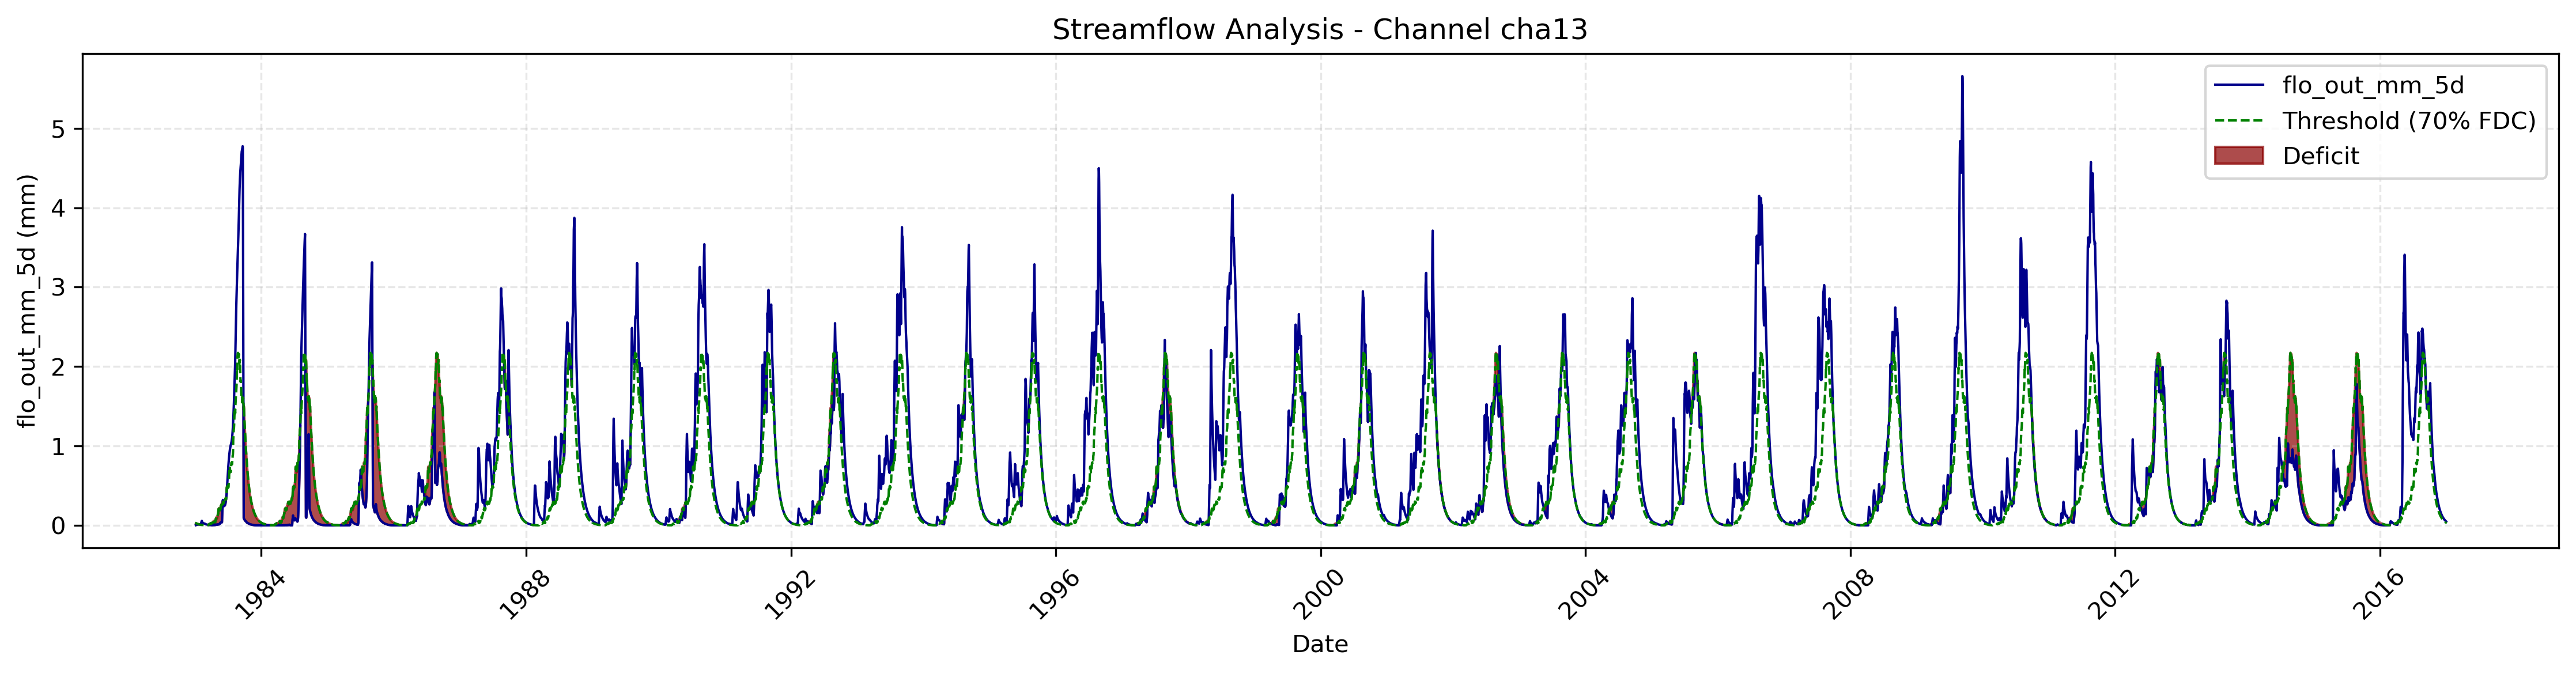


Analysis complete!
Final output: 101 precipitation events, 14 streamflow events


In [11]:
# Threshold percentiles for drought identification
PERCENTILES_TO_ANALYZE = [0.01, 0.05, 0.1, 0.2, 0.3]
DROUGHT_THRESHOLD_PERCENTILE = 0.3  # 30th percentile (70% FDC)

# Pooling procedure parameters
TMIN_DAYS = 3  # Minimum time between independent drought events (days)
DMIN_DAYS = 5  # Minimum drought duration (days)
MIN_DEFICIT_VOLUME_FRACTION = 0.05  # Minimum deficit volume as fraction of max (5%)

# Number of days to analyze (13149 days ≈ 36 years)
N_DAYS_TO_ANALYZE = 13149
# ===========================================================================================

print(f"Running analysis for LSU ID: {lsu_id}, Channel ID: {channel_id}")
print('='*80)

# ===========================================================================================
# PART 1: PRECIPITATION DEFICIT ANALYSIS
# ===========================================================================================

def calculate_percentile_thresholds(data, var_name, percentiles):
    """
    Calculate percentile thresholds for each day of year using ECDF.
    
    Parameters:
    -----------
    data : pd.DataFrame
        Input data containing 'jday' and the variable to analyze
    var_name : str
        Name of the variable to analyze
    percentiles : list
        List of percentiles to calculate (e.g., [0.01, 0.05, 0.1, 0.2, 0.3])
    
    Returns:
    --------
    dict : Dictionary of DataFrames, one for each percentile
    """
    percentile_data = []
    
    # Calculate ECDF for each Julian day
    fig, ax = plt.subplots(figsize=(12, 8))
    
    for day in range(1, 367):
        ax.clear()
        day_data = data[data.jday == day]
        
        if len(day_data) == 0:
            continue
            
        sns.ecdfplot(data=day_data, x=var_name, hue="jday", ax=ax)
        
        # Extract percentile values from ECDF
        for line in ax.get_lines():
            x_vals, y_vals = line.get_data()
            
            for target_percentile in percentiles:
                # Find the x-value corresponding to the target percentile
                idx = next((i for i, y in enumerate(y_vals) if y >= target_percentile), None)
                
                if idx is not None:
                    threshold_value = x_vals[idx]
                    percentile_data.append({
                        'jday': day, 
                        var_name: threshold_value, 
                        'percentile': round(target_percentile, 2)
                    })
    
    plt.close(fig)
    
    # Convert to DataFrame and split by percentile
    all_percentiles_df = pd.DataFrame(percentile_data)
    
    # Create separate DataFrames for each percentile
    percentile_dfs = {}
    for p in percentiles:
        p_key = int(p * 100)  # Convert to percentage for key
        percentile_dfs[p_key] = all_percentiles_df[all_percentiles_df.percentile == p]
    
    return percentile_dfs, all_percentiles_df

def create_daily_threshold_array(data, percentile_df, var_name):
    """
    Create an array of threshold values aligned with the input data dates.
    """
    threshold_values = []
    
    for _, row in data.iterrows():
        jday = row['jday']
        matching_rows = percentile_df[percentile_df['jday'] == jday]
        
        if len(matching_rows) > 0:
            threshold_value = matching_rows[var_name].iloc[0]
        else:
            # Handle missing days by using nearest day
            threshold_value = np.nan
            
        threshold_values.append(threshold_value)
    
    return np.array(threshold_values)

def identify_deficit_periods(data, values, thresholds, date_column='date'):
    """
    Identify periods where values fall below thresholds.
    """
    deficit_periods = []
    
    # Find indices where deficit occurs
    deficit_mask = values < thresholds
    deficit_indices = np.where(deficit_mask)[0]
    
    if len(deficit_indices) == 0:
        return pd.DataFrame(deficit_periods)
    
    # Group consecutive deficit indices
    start_idx = deficit_indices[0]
    
    for i in range(len(deficit_indices) - 1):
        # Check if next index is consecutive
        if deficit_indices[i + 1] != deficit_indices[i] + 1:
            # End of current deficit period
            end_idx = deficit_indices[i]
            
            # Calculate deficit characteristics
            start_date = data.iloc[start_idx][date_column]
            end_date = data.iloc[end_idx][date_column]
            
            # Sum of deficits (threshold - actual value)
            deficit_sum = np.sum(thresholds[start_idx:end_idx+1] - values[start_idx:end_idx+1])
            
            # Duration in days
            duration_days = (end_date - start_date).days + 1
            
            deficit_periods.append({
                'start_date': start_date,
                'end_date': end_date,
                'sum_y_values': deficit_sum,
                'num_days': duration_days
            })
            
            # Start new period
            start_idx = deficit_indices[i + 1]
    
    # Handle last deficit period
    if len(deficit_indices) > 0:
        end_idx = deficit_indices[-1]
        start_date = data.iloc[start_idx][date_column]
        end_date = data.iloc[end_idx][date_column]
        deficit_sum = np.sum(thresholds[start_idx:end_idx+1] - values[start_idx:end_idx+1])
        duration_days = (end_date - start_date).days + 1
        
        deficit_periods.append({
            'start_date': start_date,
            'end_date': end_date,
            'sum_y_values': deficit_sum,
            'num_days': duration_days
        })
    
    return pd.DataFrame(deficit_periods)

def pool_dependent_droughts(drought_df, tmin=3):
    """
    Pool dependent drought events that are separated by less than tmin days.
    This function remains unchanged from the original.
    """
    if len(drought_df) <= 1:
        return drought_df
    
    pooled_droughts = []
    current_drought = drought_df.iloc[0].to_dict()
    
    for i in range(1, len(drought_df)):
        next_drought = drought_df.iloc[i]
        time_between = (next_drought['start_date'] - current_drought['end_date']).days
        
        if time_between <= tmin:
            # Pool the droughts
            current_drought['end_date'] = next_drought['end_date']
            current_drought['sum_y_values'] += next_drought['sum_y_values']
            current_drought['num_days'] = (current_drought['end_date'] - current_drought['start_date']).days + 1
        else:
            # Save current drought and start a new one
            pooled_droughts.append(current_drought)
            current_drought = next_drought.to_dict()
    
    # Don't forget the last drought
    pooled_droughts.append(current_drought)
    
    return pd.DataFrame(pooled_droughts)

def filter_minor_droughts(drought_df, dmin_days, min_volume_fraction):
    """
    Filter out minor droughts based on duration and volume criteria.
    """
    if len(drought_df) == 0:
        return drought_df
    
    # Calculate maximum deficit volume
    max_deficit_volume = drought_df['sum_y_values'].max()
    min_deficit_volume = max_deficit_volume * min_volume_fraction
    
    # Flag minor droughts
    drought_df['Minor'] = (
        (drought_df['num_days'] < dmin_days) | 
        (drought_df['sum_y_values'] < min_deficit_volume)
    )
    
    return drought_df

print("Analyzing precipitation deficits...")

# Calculate percentile thresholds for precipitation
precip_percentile_dfs, _ = calculate_percentile_thresholds(
    lsu_data, 
    lsu_var_to_analyze, 
    PERCENTILES_TO_ANALYZE
)

# Get the drought threshold (30th percentile = 70% FDC)
drought_threshold_key = int(DROUGHT_THRESHOLD_PERCENTILE * 100)
precip_threshold_df = precip_percentile_dfs[drought_threshold_key]

# Create daily threshold array
precip_daily_thresholds = create_daily_threshold_array(
    lsu_data, 
    precip_threshold_df, 
    lsu_var_to_analyze
)

# Ensure numeric data type
lsu_data[lsu_var_to_analyze] = pd.to_numeric(lsu_data[lsu_var_to_analyze], errors='coerce')
lsu_data.reset_index(drop=True, inplace=True)

# Subset data to analysis period
precip_data_subset = lsu_data[:N_DAYS_TO_ANALYZE].copy()
precip_values_subset = precip_data_subset[lsu_var_to_analyze].values
precip_thresholds_subset = precip_daily_thresholds[:N_DAYS_TO_ANALYZE]

# Identify deficit periods
precip_deficits = identify_deficit_periods(
    precip_data_subset,
    precip_values_subset,
    precip_thresholds_subset
)

# Add temporal information
precip_deficits['start_month'] = precip_deficits['start_date'].dt.month
precip_deficits['end_month'] = precip_deficits['end_date'].dt.month
precip_deficits['start_year'] = precip_deficits['start_date'].dt.year
precip_deficits['end_year'] = precip_deficits['end_date'].dt.year

# Filter minor droughts (pre-pooling)
precip_deficits = filter_minor_droughts(
    precip_deficits, 
    DMIN_DAYS, 
    MIN_DEFICIT_VOLUME_FRACTION
)

# Pool dependent droughts
precip_deficits_pooled = pool_dependent_droughts(precip_deficits, tmin=TMIN_DAYS)
precip_deficits_pooled['dbt_pp'] = (
    precip_deficits_pooled['end_date'] - precip_deficits_pooled['start_date']
).dt.days + 1

# Filter minor droughts again (post-pooling)
precip_deficits_pooled = filter_minor_droughts(
    precip_deficits_pooled, 
    DMIN_DAYS, 
    MIN_DEFICIT_VOLUME_FRACTION
)
precip_deficits_pooled['Minor_pp'] = precip_deficits_pooled['Minor']

# Get final precipitation drought events
precip_df = precip_deficits_pooled[precip_deficits_pooled['Minor_pp'] == False].copy()

print(f"Identified {len(precip_df)} significant precipitation deficit events")

# Create visualization for precipitation
fig, ax = plt.subplots(figsize=(15, 4), dpi=300)

# Plot time series and threshold
ax.plot(precip_data_subset['date'], precip_values_subset, 
        label=f'{lsu_var_to_analyze}', color='darkblue', linewidth=1)
ax.plot(precip_data_subset['date'], precip_thresholds_subset, 
        label=f"Threshold ({int((1-DROUGHT_THRESHOLD_PERCENTILE)*100)}% FDC)", 
        color='green', linestyle='--', linewidth=1)

# Shade deficit periods
ax.fill_between(precip_data_subset['date'], precip_values_subset, precip_thresholds_subset,
                where=(precip_values_subset < precip_thresholds_subset),
                color='darkred', alpha=0.7, label='Deficit')

ax.set_xlabel('Date')
ax.set_ylabel(f'{lsu_var_to_analyze} (mm)')
ax.set_title(f'Precipitation Analysis - LSU {lsu_id}')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ===========================================================================================
# PART 2: STREAMFLOW DEFICIT ANALYSIS
# ===========================================================================================

print("\nAnalyzing streamflow deficits...")

# Calculate percentile thresholds for streamflow
flow_percentile_dfs, _ = calculate_percentile_thresholds(
    channel_data, 
    cha_var_to_analyze, 
    PERCENTILES_TO_ANALYZE
)

# Get the drought threshold (30th percentile = 70% FDC)
flow_threshold_df = flow_percentile_dfs[drought_threshold_key]

# Create daily threshold array (aligned with lsu_data dates for consistency)
flow_daily_thresholds = create_daily_threshold_array(
    lsu_data,  # Use lsu_data for alignment
    flow_threshold_df, 
    cha_var_to_analyze
)

# Ensure numeric data type
channel_data[cha_var_to_analyze] = pd.to_numeric(channel_data[cha_var_to_analyze], errors='coerce')
channel_data.reset_index(drop=True, inplace=True)

# Subset data to analysis period
flow_data_subset = channel_data[:N_DAYS_TO_ANALYZE].copy()
flow_values_subset = flow_data_subset[cha_var_to_analyze].values
flow_thresholds_subset = flow_daily_thresholds[:N_DAYS_TO_ANALYZE]

# Identify deficit periods
flow_deficits = identify_deficit_periods(
    flow_data_subset,
    flow_values_subset,
    flow_thresholds_subset
)

# Add temporal information
flow_deficits['start_month'] = flow_deficits['start_date'].dt.month
flow_deficits['end_month'] = flow_deficits['end_date'].dt.month
flow_deficits['start_year'] = flow_deficits['start_date'].dt.year
flow_deficits['end_year'] = flow_deficits['end_date'].dt.year

# Filter minor droughts (pre-pooling)
flow_deficits = filter_minor_droughts(
    flow_deficits, 
    DMIN_DAYS, 
    MIN_DEFICIT_VOLUME_FRACTION
)

# Pool dependent droughts
flow_deficits_pooled = pool_dependent_droughts(flow_deficits, tmin=TMIN_DAYS)
flow_deficits_pooled['dbt_pp'] = (
    flow_deficits_pooled['end_date'] - flow_deficits_pooled['start_date']
).dt.days + 1

# Filter minor droughts again (post-pooling)
flow_deficits_pooled = filter_minor_droughts(
    flow_deficits_pooled, 
    DMIN_DAYS, 
    MIN_DEFICIT_VOLUME_FRACTION
)
flow_deficits_pooled['Minor_pp'] = flow_deficits_pooled['Minor']

# Get final streamflow drought events
flow_df = flow_deficits_pooled[flow_deficits_pooled['Minor_pp'] == False].copy()

print(f"Identified {len(flow_df)} significant streamflow deficit events")

# Create visualization for streamflow
fig, ax = plt.subplots(figsize=(15, 4), dpi=300)

# Plot time series and threshold
ax.plot(flow_data_subset['date'], flow_values_subset, 
        label=f'{cha_var_to_analyze}', color='darkblue', linewidth=1)
ax.plot(flow_data_subset['date'], flow_thresholds_subset, 
        label=f"Threshold ({int((1-DROUGHT_THRESHOLD_PERCENTILE)*100)}% FDC)", 
        color='green', linestyle='--', linewidth=1)

# Shade deficit periods
ax.fill_between(flow_data_subset['date'], flow_values_subset, flow_thresholds_subset,
                where=(flow_values_subset < flow_thresholds_subset),
                color='darkred', alpha=0.7, label='Deficit')

ax.set_xlabel('Date')
ax.set_ylabel(f'{cha_var_to_analyze} (mm)')
ax.set_title(f'Streamflow Analysis - Channel {channel_id}')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ===========================================================================================
# PREPARE OUTPUT DATAFRAMES
# ===========================================================================================

# Add suffixes to distinguish precipitation and streamflow data
precip_df = precip_df.add_suffix('_precip')
flow_df = flow_df.add_suffix('_streamflow')

print("\nAnalysis complete!")
print(f"Final output: {len(precip_df)} precipitation events, {len(flow_df)} streamflow events")
print('='*80)

**Get Metrics describing drought propagation characteristics. Total events, Likelihood of propagation, Lag, Lengthening and Attenuation patterns.**

In [12]:
# Prepare a list for the merged events
aligned_events = []

for _, q_event in flow_df.iterrows():
    aggregated_p = aggregate_p_events_within_q(precip_df, q_event)
    if aggregated_p:
        aligned_event = {**aggregated_p, **q_event.to_dict()}
        aligned_events.append(aligned_event)

# Convert back to a DataFrame
aligned_df = pd.DataFrame(aligned_events)
aligned_df

standalone_p, standalone_q = calculate_standalone_events(precip_df, flow_df, aligned_df)

# Calculate metrics
total_p_events = len(precip_df)
total_q_events = len(flow_df)
aligned_events = len(aligned_df)

# Standalone events
standalone_p_count = len(standalone_p)
standalone_q_count = len(standalone_q)

# P-to-Q Likelihood
p_to_q_likelihood = aligned_events / total_p_events if total_p_events > 0 else 0

# Lag metrics
aligned_df['Lag'] = (aligned_df['start_date_streamflow'] - aligned_df['start_date_precip']).dt.days
mean_lag_days = aligned_df['Lag'].mean() if not aligned_df.empty else None
max_lag_days = aligned_df['Lag'].max() if not aligned_df.empty else None
min_lag_days = aligned_df['Lag'].min() if not aligned_df.empty else None
median_lag_days = aligned_df['Lag'].median() if not aligned_df.empty else None

#Duration Ratios
#aligned_df['Lengthening'] = aligned_df['dbt_pp_streamflow']- aligned_df['dbt_pp_precip'] #this does not seem to be the correct equation for lengthening
aligned_df['Lengthening'] = aligned_df['end_date_streamflow']- aligned_df['end_date_precip']
mean_duration_days = aligned_df['Lengthening'].mean() if not aligned_df.empty else None
max_duration_days = aligned_df['Lengthening'].max() if not aligned_df.empty else None
min_duration_days = aligned_df['Lengthening'].min() if not aligned_df.empty else None
median_duration_days = aligned_df['Lengthening'].median() if not aligned_df.empty else None

# Severity Ratios
aligned_df['Attenuation'] = 1-(aligned_df['sum_y_values_streamflow'] / aligned_df['sum_y_values_precip'])
mean_severity_ratio = aligned_df['Attenuation'].mean() if not aligned_df.empty else None
max_severity_ratio = aligned_df['Attenuation'].max() if not aligned_df.empty else None
min_severity_ratio = aligned_df['Attenuation'].min() if not aligned_df.empty else None
median_severity_ratio = aligned_df['Attenuation'].median() if not aligned_df.empty else None

# Combine results
lsu_metrics = {
    'P_to_Q_Likelihood': p_to_q_likelihood,
    'Total_P_Events': total_p_events,
    'Total_Q_Events': total_q_events,
    
    'Mean_Lag_Days': mean_lag_days,
    'Max_Lag_Days': max_lag_days,
    'Min_Lag_Days': min_lag_days,
    'Median_Lag_Days': median_lag_days,
        
    'Mean_Severity_Ratio(1-Q/P)': mean_severity_ratio,
    'Max_Severity_Ratio(1-Q/P)': max_severity_ratio,
    'Min_Severity_Ratio(1-Q/P)': min_severity_ratio,
    'Median_Severity_Ratio(1-Q/P)': median_severity_ratio,
    
    'Mean_Duration_Difference(Q-P)': mean_duration_days,
    'Max_Duration_Difference(Q-P)': max_duration_days,
    'Min_Duration_Difference(Q-P)': min_duration_days,
    'Median_Duration_Difference(Q-P)': median_duration_days,
    
    'Standalone_P_Count': standalone_p_count,
    'Standalone_Q_Count': standalone_q_count
}
lsu_metrics

{'P_to_Q_Likelihood': 0.1188118811881188,
 'Total_P_Events': 101,
 'Total_Q_Events': 14,
 'Mean_Lag_Days': -27.25,
 'Max_Lag_Days': 6,
 'Min_Lag_Days': -285,
 'Median_Lag_Days': 0.5,
 'Mean_Severity_Ratio(1-Q/P)': -1.3246517888854583,
 'Max_Severity_Ratio(1-Q/P)': 0.6264674317116532,
 'Min_Severity_Ratio(1-Q/P)': -7.547324993125947,
 'Median_Severity_Ratio(1-Q/P)': -0.1163943985046908,
 'Mean_Duration_Difference(Q-P)': Timedelta('72 days 20:00:00'),
 'Max_Duration_Difference(Q-P)': Timedelta('183 days 00:00:00'),
 'Min_Duration_Difference(Q-P)': Timedelta('1 days 00:00:00'),
 'Median_Duration_Difference(Q-P)': Timedelta('25 days 00:00:00'),
 'Standalone_P_Count': 76,
 'Standalone_Q_Count': 2}

**Save drought propagation metrics to csv**

In [13]:
df_metrics = pd.DataFrame([lsu_metrics])
df_metrics.to_csv(f'{lsu_id}_LSU_metrics.csv', index=False)

In [14]:
# Prepare a list for the merged events
aligned_events = []

for _, q_event in flow_df.iterrows():
    aggregated_p = aggregate_p_events_within_q(precip_df, q_event)
    if aggregated_p:
        aligned_event = {**aggregated_p, **q_event.to_dict()}
        aligned_events.append(aligned_event)

# Convert back to a DataFrame
aligned_df = pd.DataFrame(aligned_events)
aligned_df

standalone_p, standalone_q = calculate_standalone_events(precip_df, flow_df, aligned_df)

standalone_p_severity = standalone_p.sum_y_values_precip
standalone_p_duration = standalone_p.dbt_pp_precip

aligned_p_severity = aligned_df.sum_y_values_precip
aligned_p_duration = aligned_df.dbt_pp_precip

lsu_metrics_standalone_and_aligned = {
    'LSU': lsu_id,
    "Channel": channel_id,
    
    'Mean_standalone_p_severity': standalone_p_severity.mean(),
    'Max_standalone_p_severity': standalone_p_severity.max(),
    'Median_standalone_p_severity': standalone_p_severity.median(),
    
    'Mean_standalone_p_duration': standalone_p_duration.mean(),
    'Max_standalone_p_duration': standalone_p_duration.max(),
    'Median_standalone_p_duration': standalone_p_duration.median(),
    
    'Mean_aligned_p_severity': aligned_p_severity.mean(),
    'Max_aligned_p_severity': aligned_p_severity.max(),
    'Median_aligned_p_severity': aligned_p_severity.median(),
    
    'Mean_aligned_p_duration': aligned_p_duration.mean(),
    'Max_aligned_p_duration': aligned_p_duration.max(),
    'Median_aligned_p_duration': aligned_p_duration.median(),
}
lsu_metrics_standalone_and_aligned

{'LSU': 'rtu132',
 'Channel': 'cha13',
 'Mean_standalone_p_severity': 16.356871052631572,
 'Max_standalone_p_severity': 69.71399999999987,
 'Median_standalone_p_severity': 13.838399999999975,
 'Mean_standalone_p_duration': 9.144736842105264,
 'Max_standalone_p_duration': 27,
 'Median_standalone_p_duration': 8.0,
 'Mean_aligned_p_severity': 31.1069,
 'Max_aligned_p_severity': 96.75140000000033,
 'Median_aligned_p_severity': 27.373999999999903,
 'Mean_aligned_p_duration': 20.583333333333332,
 'Max_aligned_p_duration': 47,
 'Median_aligned_p_duration': 16.0}

**Save metrics for both propagating and non propagating droughts to csv**

In [15]:
df_metrics_standalone_and_aligned = pd.DataFrame([lsu_metrics_standalone_and_aligned])
df_metrics_standalone_and_aligned.to_csv(f'{lsu_id}_LSU_standalone_vs_aligned_metrics.csv', index=False)

In [16]:
# Prepare lists for different relationship types
all_relationships = []

for _, q_event in flow_df.iterrows():
    relationships = identify_drought_relationships(precip_df, q_event)
    
    # Add streamflow event info to each relationship record
    q_event_dict = q_event.to_dict()
    
    # Process initiating relationship
    if relationships['initiating']:
        relationship_record = {**relationships['initiating'], **q_event_dict}
        relationship_record['event_id'] = f"Q{pd.to_datetime(q_event['start_date_streamflow']).strftime('%Y%m%d')}"
        all_relationships.append(relationship_record)
    
    # Process sustaining relationships
    for sustaining_rel in relationships['sustaining']:
        relationship_record = {**sustaining_rel, **q_event_dict}
        relationship_record['event_id'] = f"Q{pd.to_datetime(q_event['start_date_streamflow']).strftime('%Y%m%d')}"
        all_relationships.append(relationship_record)

# Convert to DataFrame
relationships_df = pd.DataFrame(all_relationships)

# Add detailed classification
def classify_relationship(row):
    if row['relationship_type'] == 'initiating':
        if pd.isna(row['gap_after_p']) or row['gap_after_p'] <= 0:
            return 'direct_initiating'  # P drought continues into Q drought
        else:
            return 'delayed_initiating'  # Gap exists
    else:
        return 'sustaining'
        
relationships_df['detailed_relationship'] = relationships_df.apply(classify_relationship, axis=1)
relationships_df['lsu_id'] = lsu_id
relationships_df['channel_id'] = channel_id

In [17]:
# Group by event_id and count relationships
event_relationship_counts = relationships_df.groupby(['event_id', 'relationship_type']).size().unstack(fill_value=0)

# Identify events with both initiating and sustaining deficits
complex_events = event_relationship_counts[(event_relationship_counts['initiating'] > 0) & 
                                          (event_relationship_counts['sustaining'] > 0)]

# Sort by number of sustaining events to highlight those with many sustaining deficits
complex_events = complex_events.sort_values('sustaining', ascending=False)

print(f"Found {len(complex_events)} streamflow drought events with both initiating and sustaining precipitation deficits")

Found 6 streamflow drought events with both initiating and sustaining precipitation deficits


In [18]:
# Count relationships per event
relationship_counts = relationships_df.groupby('event_id').size().reset_index(name='relationship_count')

# Add this back to your main dataframe
relationships_df = relationships_df.merge(relationship_counts, on='event_id', how='left')

# Flag events with multiple relationships
relationships_df['complex_event'] = relationships_df['relationship_count'] > 1
relationships_df

,start_date_precip,end_date_precip,sum_y_values_precip,num_days_precip,start_month_precip,end_month_precip,start_year_precip,end_year_precip,Minor_precip,dbt_pp_precip,...,end_year_streamflow,Minor_streamflow,dbt_pp_streamflow,Minor_pp_streamflow,event_id,detailed_relationship,lsu_id,channel_id,relationship_count,complex_event
0,1983-06-23,1983-07-14,69.7140,22,6,7,1983,1983,False,22,...,1983,False,102,False,Q19830317,sustaining,rtu132,cha13,1,False
1,1984-07-06,1984-07-10,8.6848,5,7,7,1984,1984,False,5,...,1984,False,314,False,Q19830925,sustaining,rtu132,cha13,1,False
2,1984-08-24,1984-09-02,12.5428,10,8,8,1984,1984,False,10,...,1985,False,296,False,Q19840901,direct_initiating,rtu132,cha13,3,True
3,1984-09-14,1984-09-25,12.8784,12,9,9,1984,1984,False,12,...,1985,False,296,False,Q19840901,sustaining,rtu132,cha13,3,True
4,1985-05-27,1985-06-20,18.9014,25,5,6,1985,1985,False,25,...,1985,False,296,False,Q19840901,sustaining,rtu132,cha13,3,True
5,1985-07-14,1985-07-19,6.5298,6,7,7,1985,1985,False,6,...,1985,False,39,False,Q19850707,sustaining,rtu132,cha13,1,False
6,1985-08-31,1985-09-05,5.0634,6,8,9,1985,1985,False,6,...,1986,False,172,False,Q19850906,delayed_initiating,rtu132,cha13,2,True
7,1985-09-11,1985-09-15,3.5274,5,9,9,1985,1985,False,5,...,1986,False,172,False,Q19850906,sustaining,rtu132,cha13,2,True
8,1986-07-09,1986-07-23,25.7982,15,7,7,1986,1986,False,15,...,1986,False,51,False,Q19860621,sustaining,rtu132,cha13,2,True
9,1986-08-03,1986-08-07,7.0734,5,8,8,1986,1986,False,5,...,1986,False,51,False,Q19860621,sustaining,rtu132,cha13,2,True


In [19]:
def identify_drought_cascades(relationships_df):
    # Find events with both initiating and multiple sustaining deficits
    cascades = []
    
    for event_id in relationships_df['event_id'].unique():
        event_data = relationships_df[relationships_df['event_id'] == event_id]
        init_count = sum(event_data['relationship_type'] == 'initiating')
        sustain_count = sum(event_data['relationship_type'] == 'sustaining')
        
        # Include all events, even if they don't have both initiating and sustaining relationships
        cascades.append({
            'event_id': event_id,
            'initiating_count': init_count,
            'sustaining_count': sustain_count,
            'cascade_complexity': init_count + sustain_count,
            'lsu_id': event_data['lsu_id'].iloc[0],  # Assuming same for all rows
            'channel_id': event_data['channel_id'].iloc[0]  # Assuming same for all rows
        })
    
    # If cascades list is empty, return an empty DataFrame with the right columns
    if not cascades:
        return pd.DataFrame(columns=['event_id', 'initiating_count', 'sustaining_count', 
                                     'cascade_complexity', 'lsu_id', 'channel_id'])
    
    return pd.DataFrame(cascades).sort_values('cascade_complexity', ascending=False)

In [20]:
cascade_summary_df = identify_drought_cascades(relationships_df)
cascade_summary_df

,event_id,initiating_count,sustaining_count,cascade_complexity,lsu_id,channel_id
13,Q20150612,1,5,6,rtu132,cha13
12,Q20140715,1,3,4,rtu132,cha13
2,Q19840901,1,2,3,rtu132,cha13
7,Q19920714,1,2,3,rtu132,cha13
4,Q19850906,1,1,2,rtu132,cha13
5,Q19860621,0,2,2,rtu132,cha13
6,Q19860814,1,1,2,rtu132,cha13
0,Q19830317,0,1,1,rtu132,cha13
1,Q19830925,0,1,1,rtu132,cha13
3,Q19850707,0,1,1,rtu132,cha13


In [ ]:
def enhance_relationship_features(relationships_df, lsu_id=None):
    """
    Enhance the drought relationships dataframe with additional calculated metrics
    
    Parameters:
    ----------
    relationships_df : pandas DataFrame
        DataFrame containing drought relationships with at minimum:
        - start_date_precip
        - end_date_precip
        - start_date_streamflow
        - end_date_streamflow
        - sum_y_values_precip
        - sum_y_values_streamflow
        - event_id
        - relationship_type
    lsu_id : str, optional
        ID of the landscape unit being processed, to be added as a column
        
    Returns:
    -------
    pandas DataFrame
        Enhanced dataframe with additional calculated metrics
    """
    # Create a copy to avoid modifying the original
    df = relationships_df.copy()
    
    # Make sure dates are datetime objects
    date_columns = ['start_date_precip', 'end_date_precip', 
                   'start_date_streamflow', 'end_date_streamflow']
    
    for col in date_columns:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col])
    
    # Add LSU identifier if provided
    if lsu_id is not None:
        df['lsu_id'] = lsu_id
    
    # Calculate duration for precipitation deficits
    df['precip_deficit_duration_days'] = (df['end_date_precip'] - df['start_date_precip']).dt.days + 1
    
    # Calculate duration for streamflow droughts
    df['streamflow_drought_duration_days'] = (df['end_date_streamflow'] - df['start_date_streamflow']).dt.days + 1
      
    # Temporal position metrics
    
    # Year
    df['precip_deficit_year'] = df['start_date_precip'].dt.year
    df['streamflow_drought_year'] = df['start_date_streamflow'].dt.year
    
    # Month
    df['precip_deficit_month'] = df['start_date_precip'].dt.month
    df['streamflow_drought_month'] = df['start_date_streamflow'].dt.month
    
    # Day of year
    df['precip_deficit_day_of_year'] = df['start_date_precip'].dt.dayofyear
    df['streamflow_drought_day_of_year'] = df['start_date_streamflow'].dt.dayofyear
    
    # Season (meteorological seasons)
    def get_season(month):
        if month in [10, 11, 12]:
            return 'Autumn'
        elif month in [3, 4, 5]:
            return 'Spring'
        elif month in [7, 8, 9]:
            return 'Summer'
        else:
            return 'JanFebORJune'
    
    df['precip_deficit_season'] = df['precip_deficit_month'].apply(get_season)
    df['streamflow_drought_season'] = df['streamflow_drought_month'].apply(get_season)
    
    # Lag time between precipitation deficit start and streamflow drought onset (days)
    df['lag_time_days'] = df['lag']
    
    # Temporal overlap calculation
    
    # Find overlap start and end dates
    df['overlap_start'] = df[['start_date_precip', 'start_date_streamflow']].max(axis=1)
    df['overlap_end'] = df[['end_date_precip', 'end_date_streamflow']].min(axis=1)
    
    # Calculate overlap duration (days)
    df['overlap_duration_days'] = (df['overlap_end'] - df['overlap_start']).dt.days + 1
    
    # Handle cases with no overlap (negative duration)
    df.loc[df['overlap_duration_days'] < 0, 'overlap_duration_days'] = 0
    
    # Calculate temporal overlap ratio
    df['temporal_overlap_ratio'] = df['overlap_duration_days'] / df['precip_deficit_duration_days']
    
    # Sequential patterns
    # Sort by LSU (if applicable) and start dates
    sort_columns = ['start_date_precip']
    if lsu_id is not None:
        sort_columns.insert(0, 'lsu_id')
    
    df = df.sort_values(by=sort_columns)
    
    # Calculate time since last deficit in the same LSU
    df['days_since_last_deficit'] = np.nan
    
    # Group by LSU if available
    if lsu_id is not None:
        for lsu in df['lsu_id'].unique():
            lsu_mask = df['lsu_id'] == lsu
            lsu_df = df[lsu_mask].copy()
            
            for i in range(1, len(lsu_df)):
                current_idx = lsu_df.index[i]
                prev_idx = lsu_df.index[i-1]
                days_diff = (lsu_df.loc[current_idx, 'start_date_precip'] - 
                             lsu_df.loc[prev_idx, 'end_date_precip']).days
                df.loc[current_idx, 'days_since_last_deficit'] = max(0, days_diff)
    else:
        for i in range(1, len(df)):
            current_idx = df.index[i]
            prev_idx = df.index[i-1]
            days_diff = (df.loc[current_idx, 'start_date_precip'] - 
                         df.loc[prev_idx, 'end_date_precip']).days
            df.loc[current_idx, 'days_since_last_deficit'] = max(0, days_diff)
    
    # Calculate deficit intensity (average deficit per day)
    df['precip_deficit_intensity'] = df['sum_y_values_precip'] / df['precip_deficit_duration_days']
    df['streamflow_deficit_intensity'] = df['sum_y_values_streamflow'] / df['streamflow_drought_duration_days']
    
    # Categorize deficits by duration
    def categorize_duration(days):
        if days <= 30:
            return 'Short'
        elif days <= 90:
            return 'Medium'
        else:
            return 'Long'
    
    df['precip_deficit_duration_category'] = df['precip_deficit_duration_days'].apply(categorize_duration)
    df['streamflow_drought_duration_category'] = df['streamflow_drought_duration_days'].apply(categorize_duration)
    
    # Calculate ratio of deficit volumes (how much streamflow deficit per mm of precip deficit)
    df['deficit_volume_ratio'] = df['sum_y_values_streamflow'] / df['sum_y_values_precip']
    
    return df

**Save full drought propagation database to csv**

In [22]:
enhanced_df = enhance_relationship_features(relationships_df, lsu_id=lsu_id)
enhanced_df.to_csv(f'{lsu_id}_fullDatabase.csv', index=False)
ml_df_enhanced = prepare_ml_features(enhanced_df)

Missing values in features:
precip_deficit_duration_days                0
precip_deficit_intensity                    0
precip_deficit_day_of_year                  0
precip_deficit_month                        0
lag_time_days                              19
temporal_overlap_ratio                      0
days_since_last_deficit                     1
precip_deficit_season_JanFebORJune          0
precip_deficit_season_Spring                0
precip_deficit_season_Summer                0
precip_deficit_duration_category_Medium     0
precip_deficit_duration_category_Short      0
lsu_id_rtu132                               0
streamflow_deficit_volume                   0
streamflow_drought_duration                 0
dtype: int64


**Optional:  complexity of initiating and sustaining deficits for each event id**

In [23]:
def plot_simplified_drought_cascade(relationships_df, event_id, figsize=(12, 5)):
    """
    Creates a simplified visualization of drought relationships using horizontal bars
    with thickness representing deficit volume.
    
    Parameters:
    - relationships_df: DataFrame containing drought relationships with start/end dates and sum_y_values
    - event_id: The event ID of the complex drought to visualize
    - figsize: Figure size tuple (width, height)
    """
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    import pandas as pd
    import numpy as np
    from matplotlib.patches import Rectangle
    
    # Filter relationships for the specific event
    event_rels = relationships_df[relationships_df['event_id'] == event_id]
    
    if len(event_rels) == 0:
        print(f"No relationships found for event {event_id}")
        return
    
    # Get the streamflow drought data
    q_start = pd.to_datetime(event_rels['start_date_streamflow'].iloc[0])
    q_end = pd.to_datetime(event_rels['end_date_streamflow'].iloc[0])
    q_deficit = event_rels['sum_y_values_streamflow'].iloc[0]
    
    # Add buffer before and after the event for context
    buffer_days = 30
    plot_start = q_start - pd.Timedelta(days=buffer_days)
    plot_end = q_end + pd.Timedelta(days=buffer_days)
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize, dpi=300)
    
    # Set up rows for different event types
    rows = {
        'streamflow': 0,
        'initiating': 1,
        'sustaining': 2
    }
    
    # Normalize thickness based on deficit volume
    max_deficit = max(event_rels['sum_y_values_precip'].max(), q_deficit)
    
    # Function to calculate height based on deficit volume
    def get_height(deficit):
        min_height = 0.3  # Minimum bar height for visibility
        max_height = 0.8  # Maximum bar height
        return min_height + (max_height - min_height) * (deficit / max_deficit)
    
    # Convert datetime to matplotlib date numbers
    q_start_num = mdates.date2num(q_start)
    q_end_num = mdates.date2num(q_end)
    
    # Plot the streamflow drought event
    q_height = get_height(q_deficit)
    q_rect = Rectangle((q_start_num, rows['streamflow'] - q_height/2), 
                      width=q_end_num - q_start_num, 
                      height=q_height,
                      facecolor='darkblue',
                      edgecolor='black',
                      alpha=0.5)
    ax.add_patch(q_rect)
    
    # Label the streamflow event
    q_center = q_start_num + (q_end_num - q_start_num)/2
    ax.text(q_center, rows['streamflow'], 
           f"Streamflow deficit: {q_deficit:.1f}",
           ha='center', va='bottom', fontsize=9)
    
    # Plot precipitation drought events
    initiating_events = event_rels[event_rels['relationship_type'] == 'initiating']
    sustaining_events = event_rels[event_rels['relationship_type'] == 'sustaining']
    
    # Plot initiating events
    for i, (_, event) in enumerate(initiating_events.iterrows()):
        p_start = pd.to_datetime(event['start_date_precip'])
        p_end = pd.to_datetime(event['end_date_precip'])
        p_deficit = event['sum_y_values_precip']
        
        # Convert to matplotlib date numbers
        p_start_num = mdates.date2num(p_start)
        p_end_num = mdates.date2num(p_end)
        
        p_height = get_height(p_deficit)
        p_rect = Rectangle((p_start_num, rows['initiating'] - p_height/2), 
                          width=p_end_num - p_start_num, 
                          height=p_height,
                          facecolor='orange',
                          edgecolor='black',
                          alpha=0.7)
        ax.add_patch(p_rect)
        
        # Label the initiating event
        p_center = p_start_num + (p_end_num - p_start_num)/2
        ax.text(p_center, rows['initiating'], 
               f"Init: {p_deficit:.1f}",
               ha='center', va='bottom', fontsize=8, rotation=90)
        
        # Add connecting line to streamflow event
        ax.plot([p_start_num, q_start_num], 
               [rows['initiating'], rows['streamflow']], 
               'k--', alpha=0.5)
    
    # Plot sustaining events
    colors = plt.cm.tab20c(range(len(sustaining_events)))
    for i, (_, event) in enumerate(sustaining_events.iterrows()):
        p_start = pd.to_datetime(event['start_date_precip'])
        p_end = pd.to_datetime(event['end_date_precip'])
        p_deficit = event['sum_y_values_precip']
        
        # Convert to matplotlib date numbers
        p_start_num = mdates.date2num(p_start)
        p_end_num = mdates.date2num(p_end)
        
        p_height = get_height(p_deficit)
        p_rect = Rectangle((p_start_num, rows['sustaining'] - p_height/2), 
                          width=p_end_num - p_start_num, 
                          height=p_height,
                          facecolor=colors[i % len(colors)],
                          edgecolor='black',
                          alpha=0.7)
        ax.add_patch(p_rect)
        
        # Label the sustaining event
        p_center = p_start_num + (p_end_num - p_start_num)/2
        ax.text(p_center, rows['sustaining'], 
               f"Sust {i+1}: {p_deficit:.1f}",
               ha='center', va='bottom', fontsize=8, rotation=90)
        
        # Add connecting line to streamflow event
        # Connect to the appropriate point in time on the streamflow event
        connect_point_time = max(q_start, p_start)
        if connect_point_time > q_end:
            connect_point_time = q_end
        connect_point_num = mdates.date2num(connect_point_time)
            
        ax.plot([p_start_num, connect_point_num], 
               [rows['sustaining'], rows['streamflow']], 
               'k--', alpha=0.5)
    
    # Set y-axis labels
    ax.set_yticks([rows['streamflow'], rows['initiating'], rows['sustaining']])
    ax.set_yticklabels(['Streamflow Drought', 'Initiating P Deficit', 'Sustaining P Deficit'])
    
    # Format x-axis as dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    plt.xticks(rotation=0)
    
    # Set x limits
    ax.set_xlim(mdates.date2num(plot_start), mdates.date2num(plot_end))
    
    # Remove y-axis line
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Set title
    ax.set_title(f'Initiating and sustaining p events for Event {event_id}')
    ax.set_xlabel('Date')
    
    # Add info about complexity
    cascade_info = f"Cascade Complexity: {len(event_rels)} events\n"
    cascade_info += f"Initiating: {len(initiating_events)}, Sustaining: {len(sustaining_events)}"
    plt.figtext(0.02, 0.18, cascade_info, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    return fig


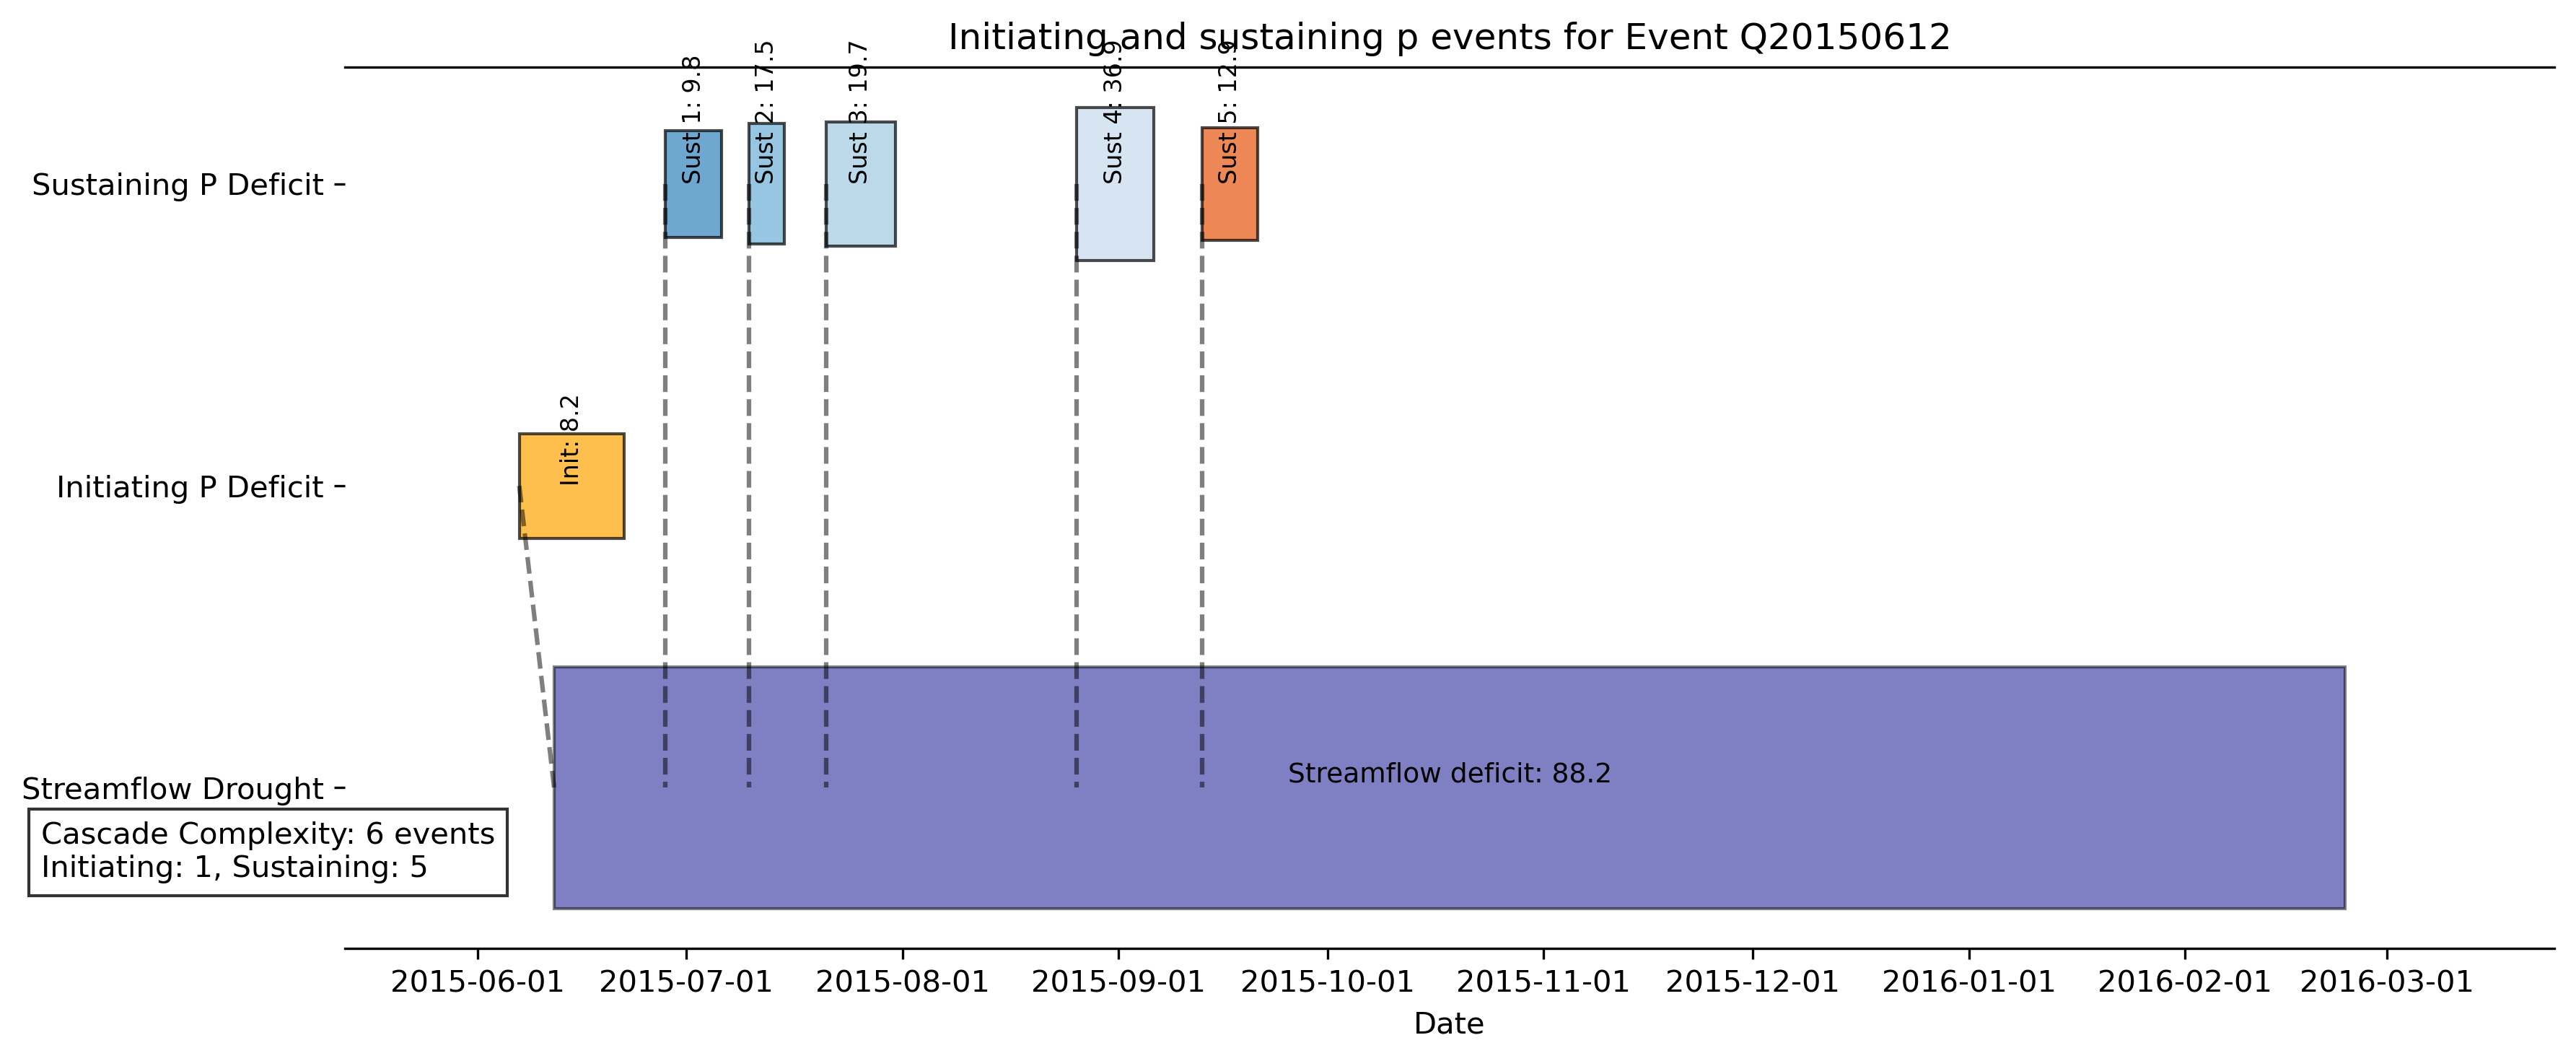

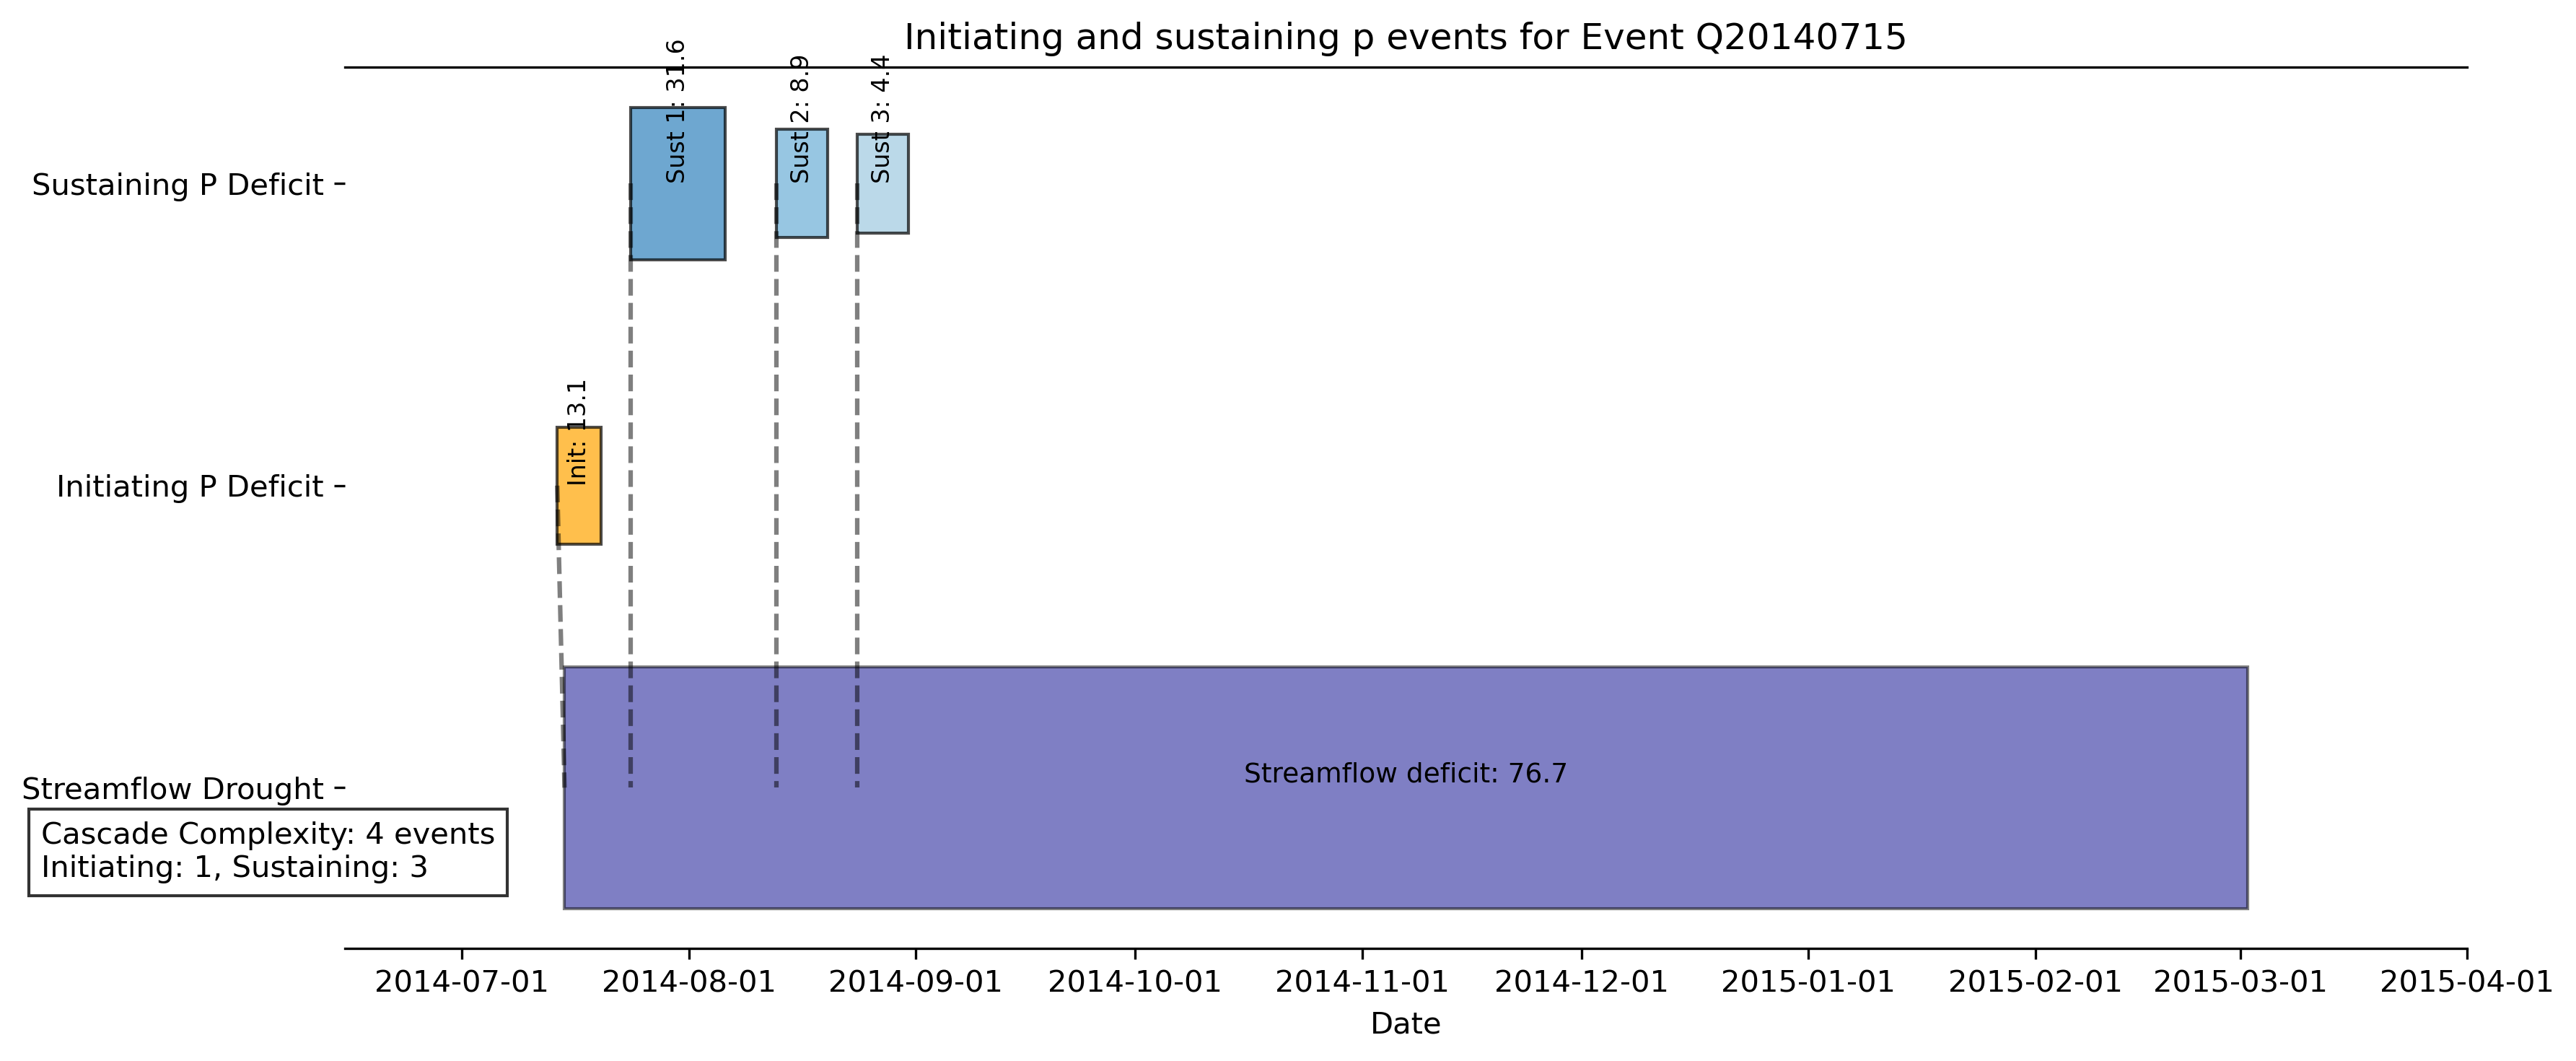

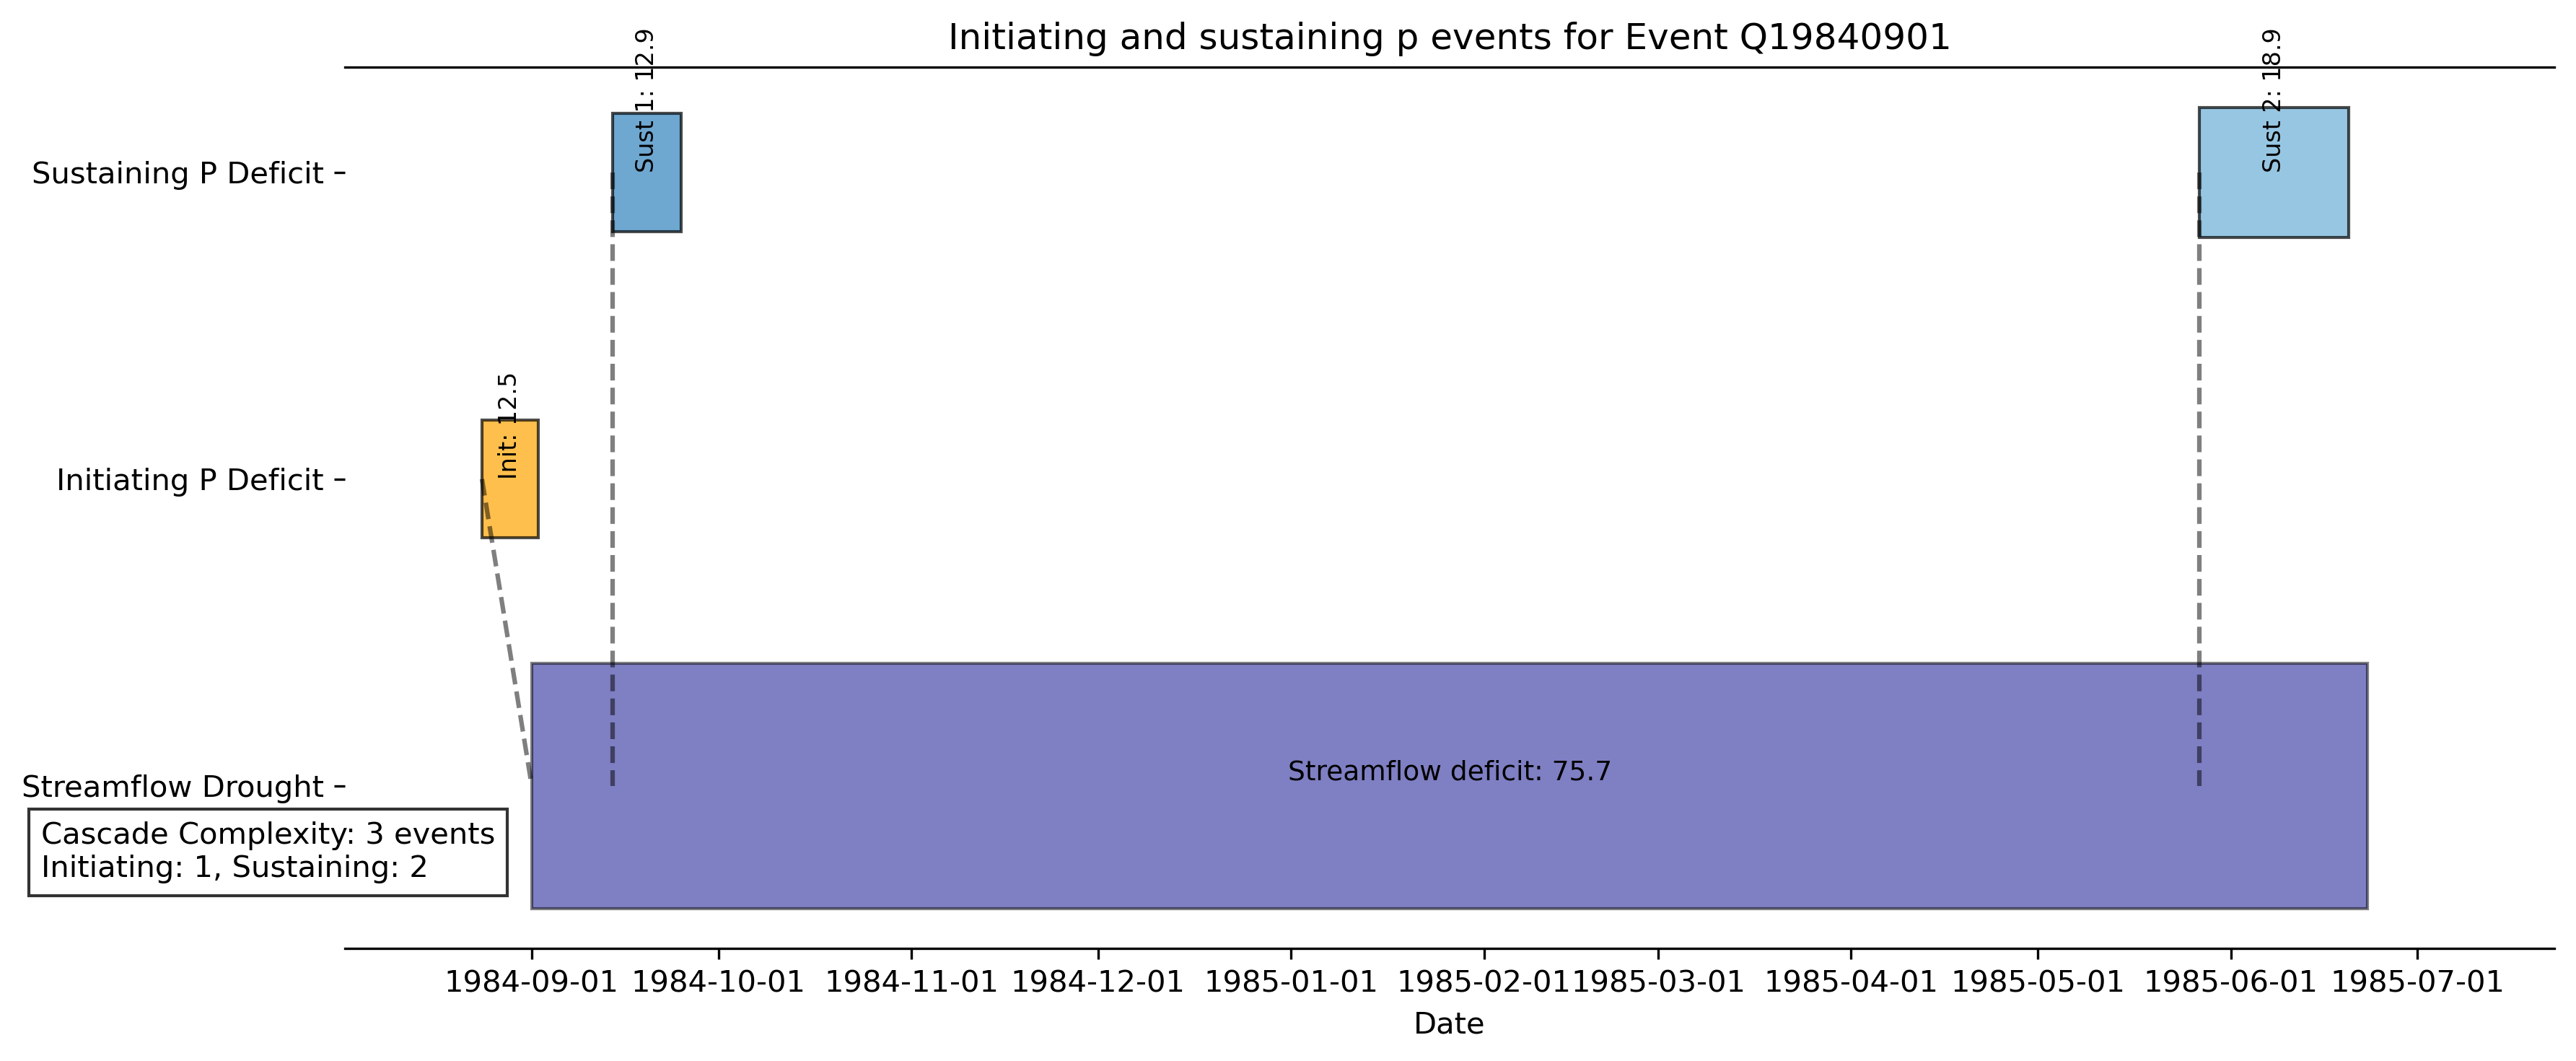

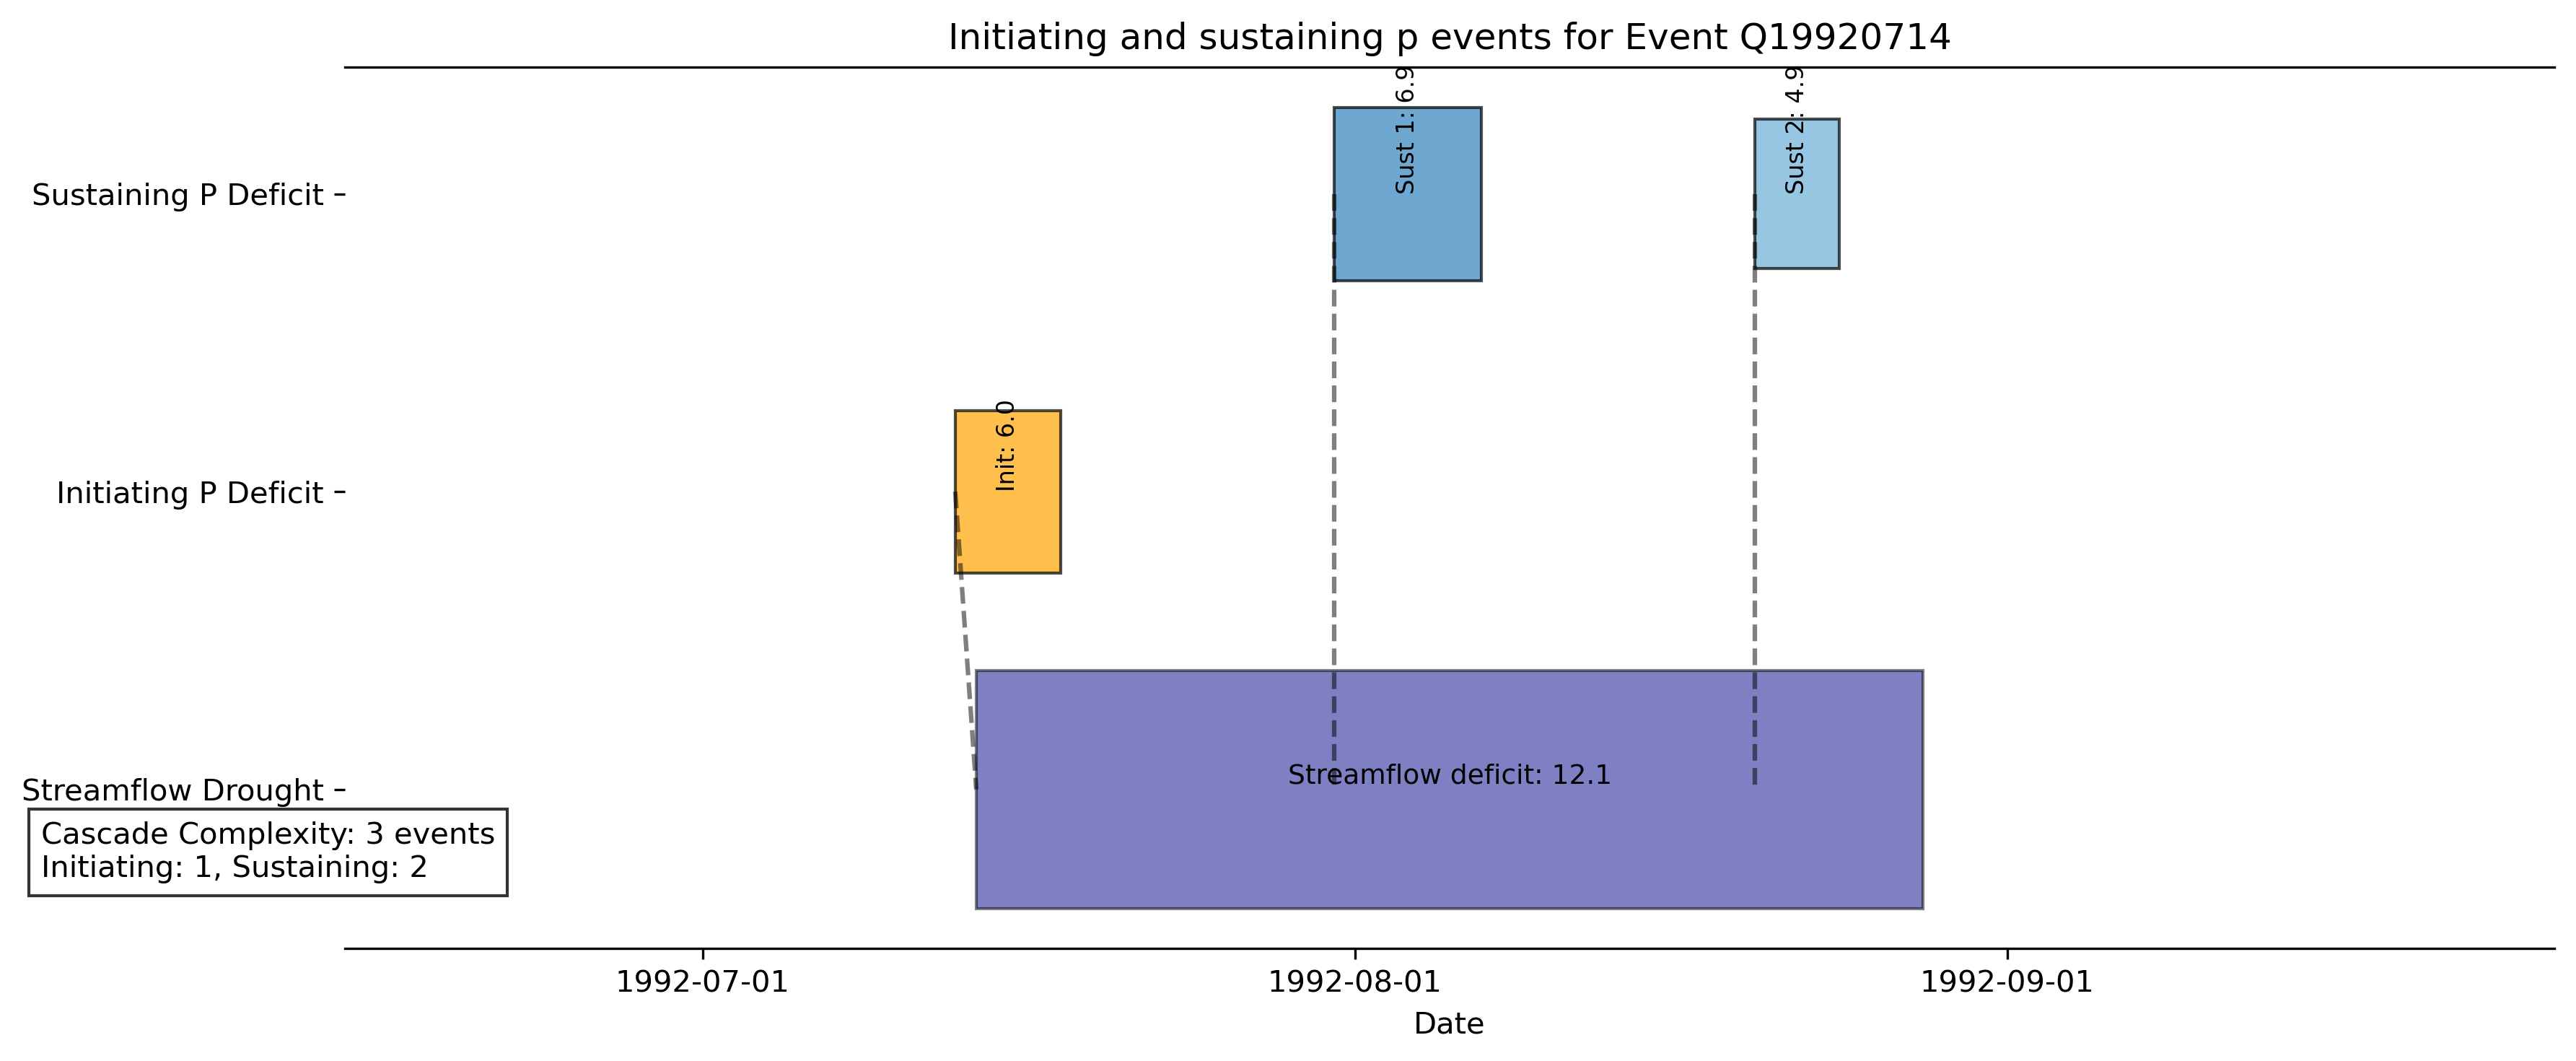

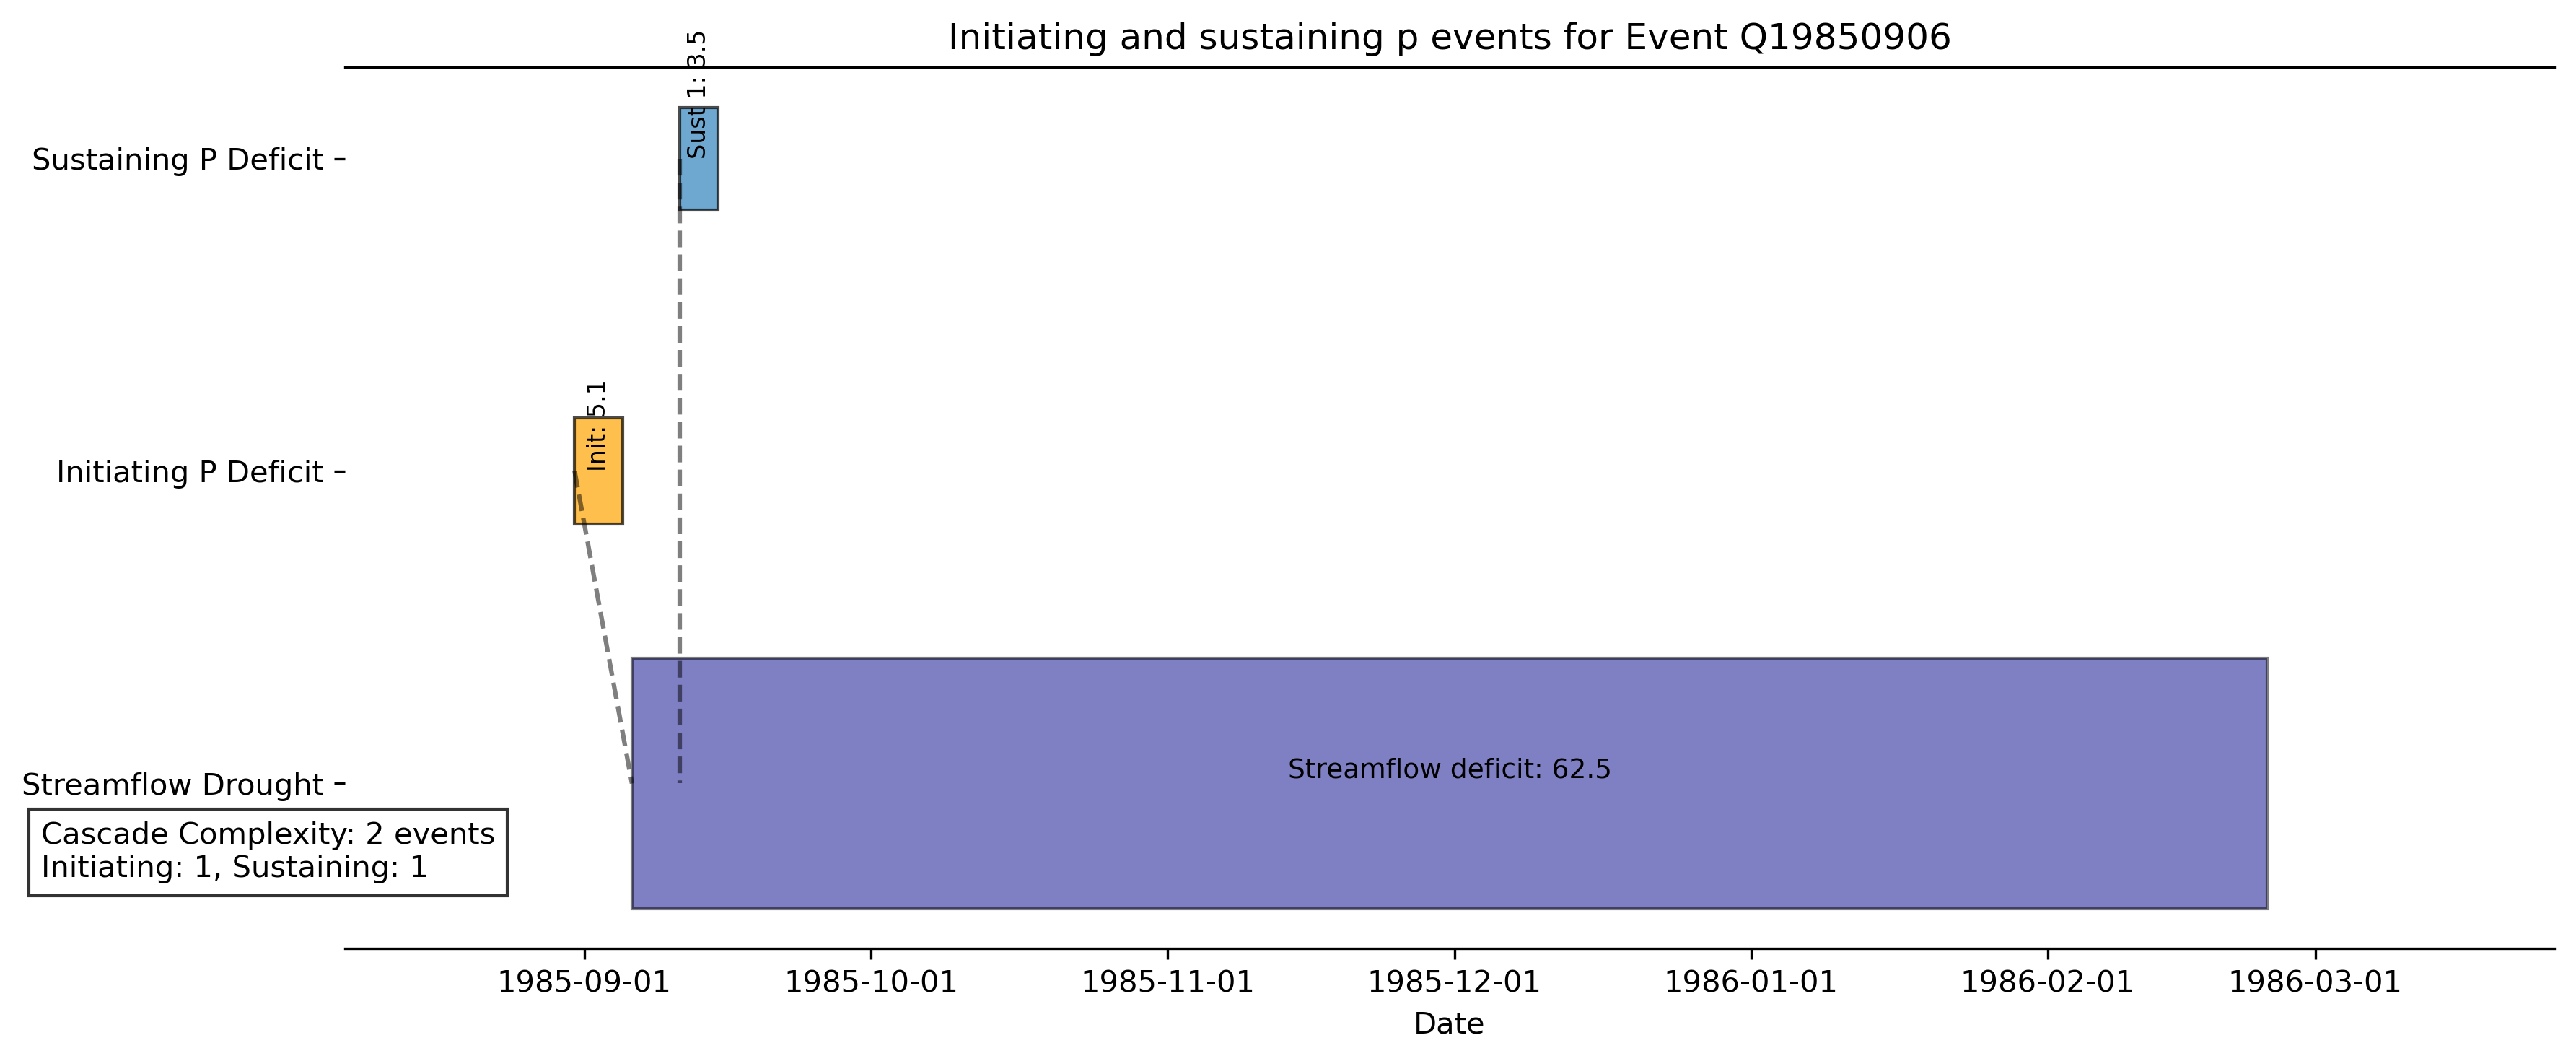

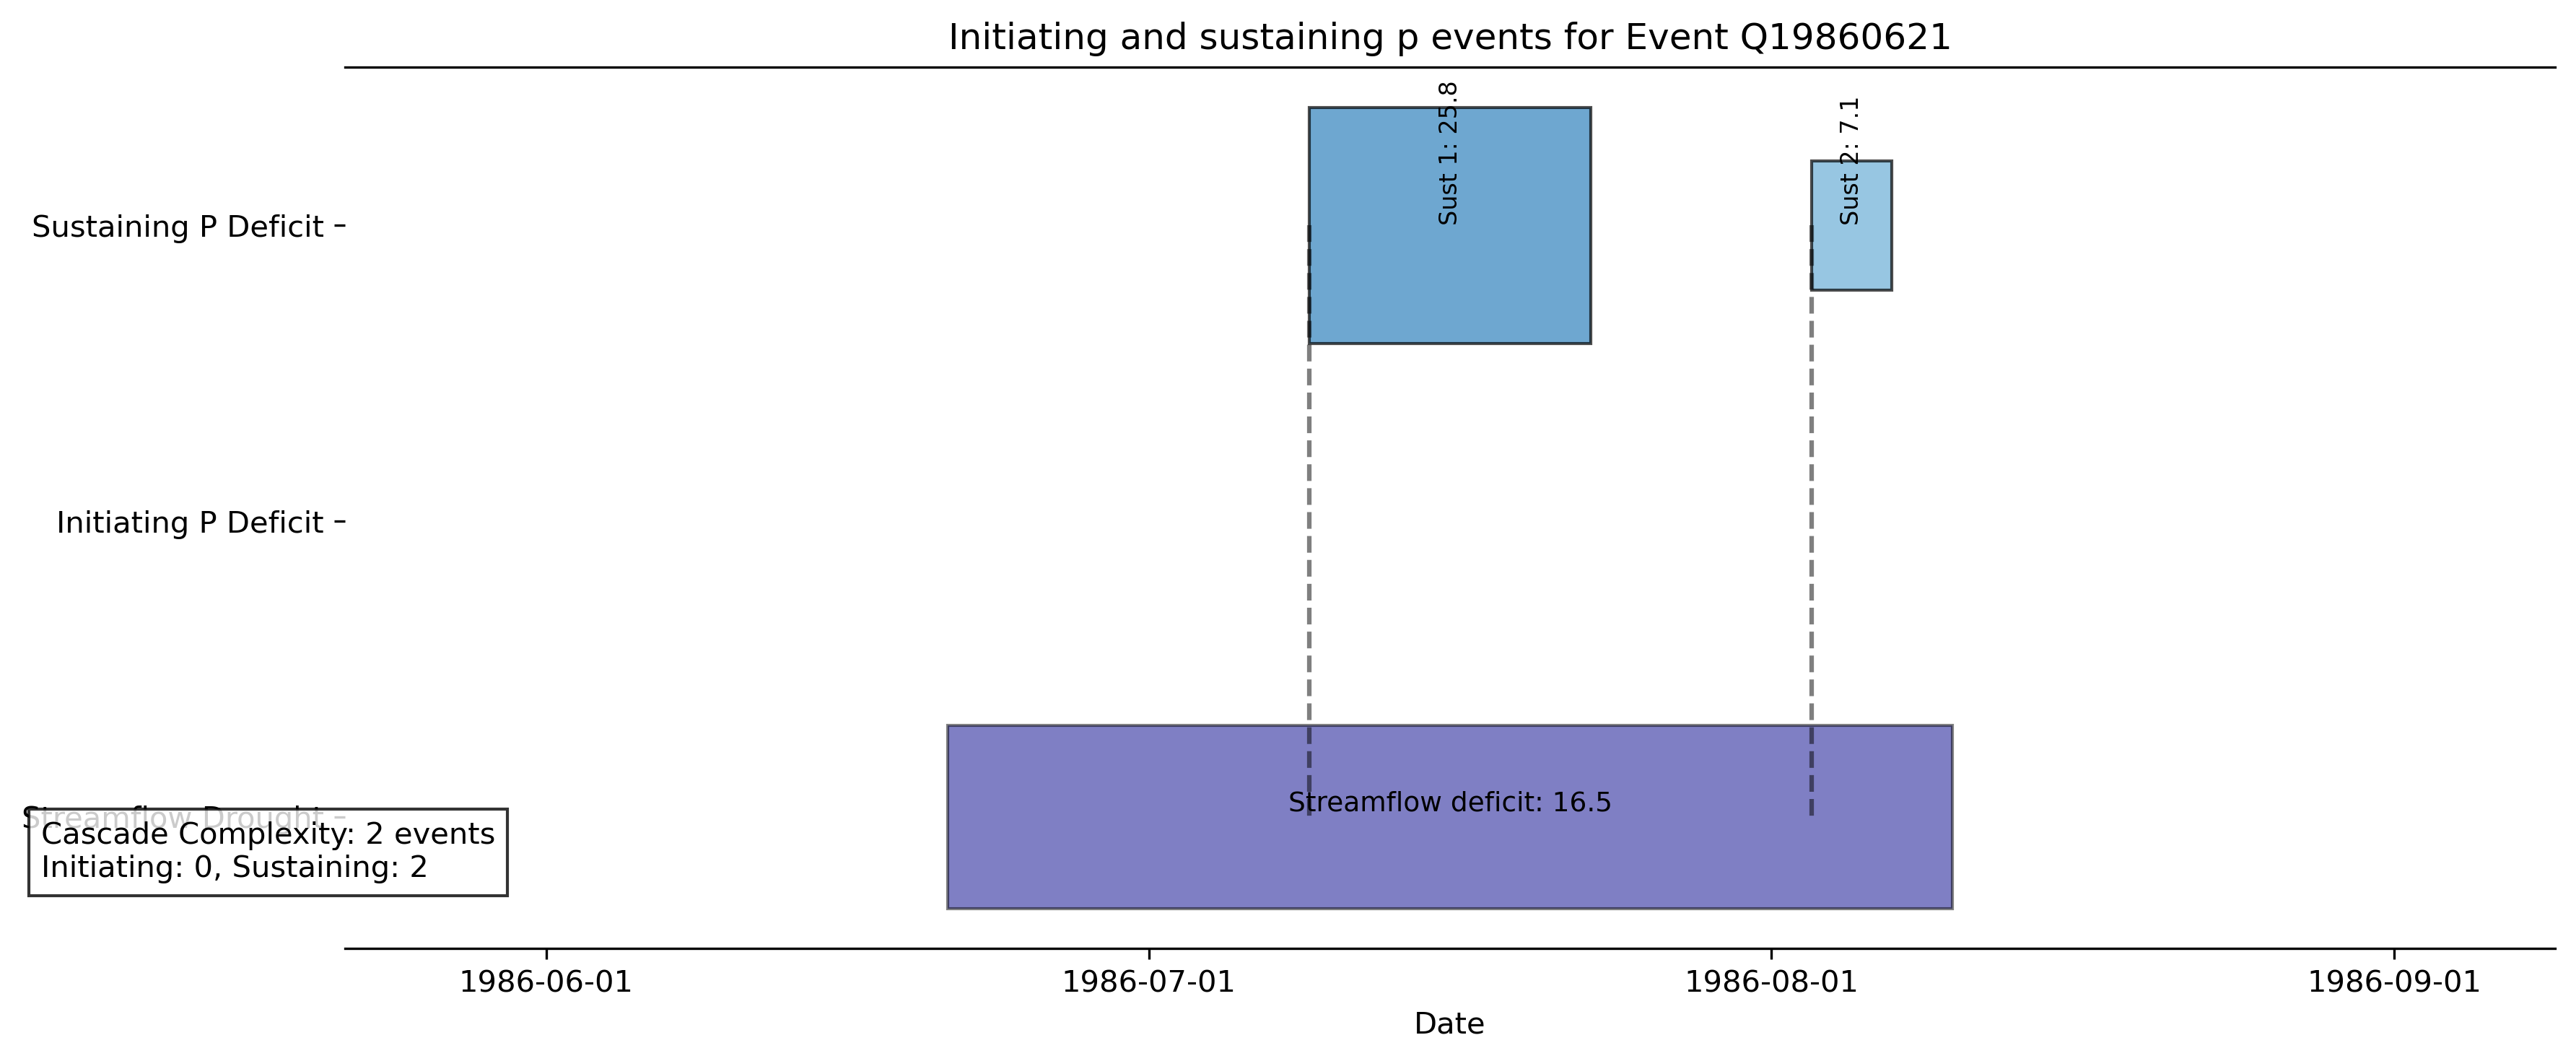

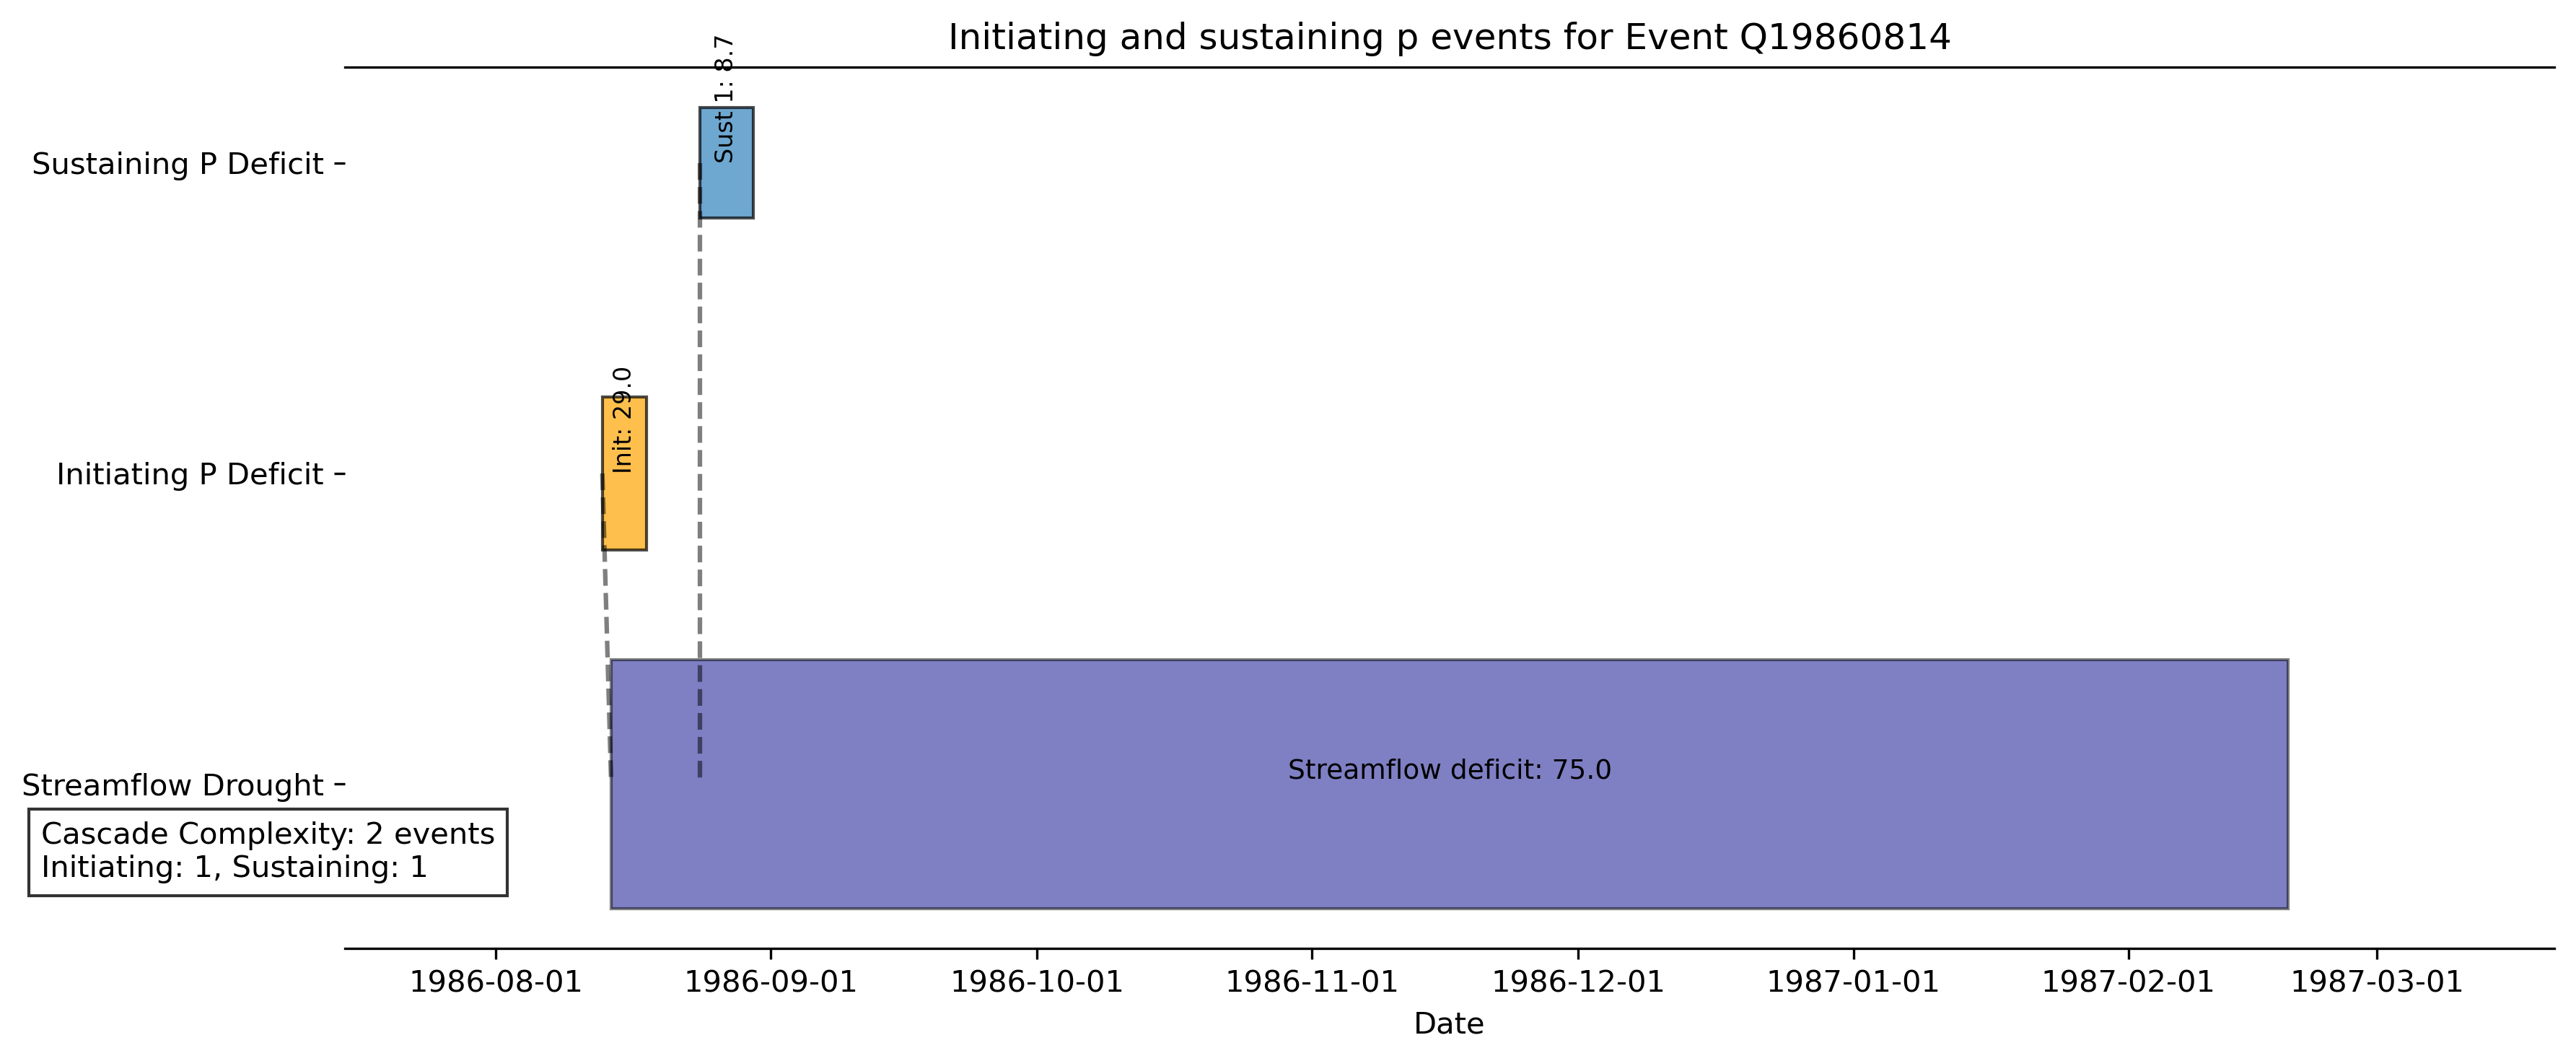

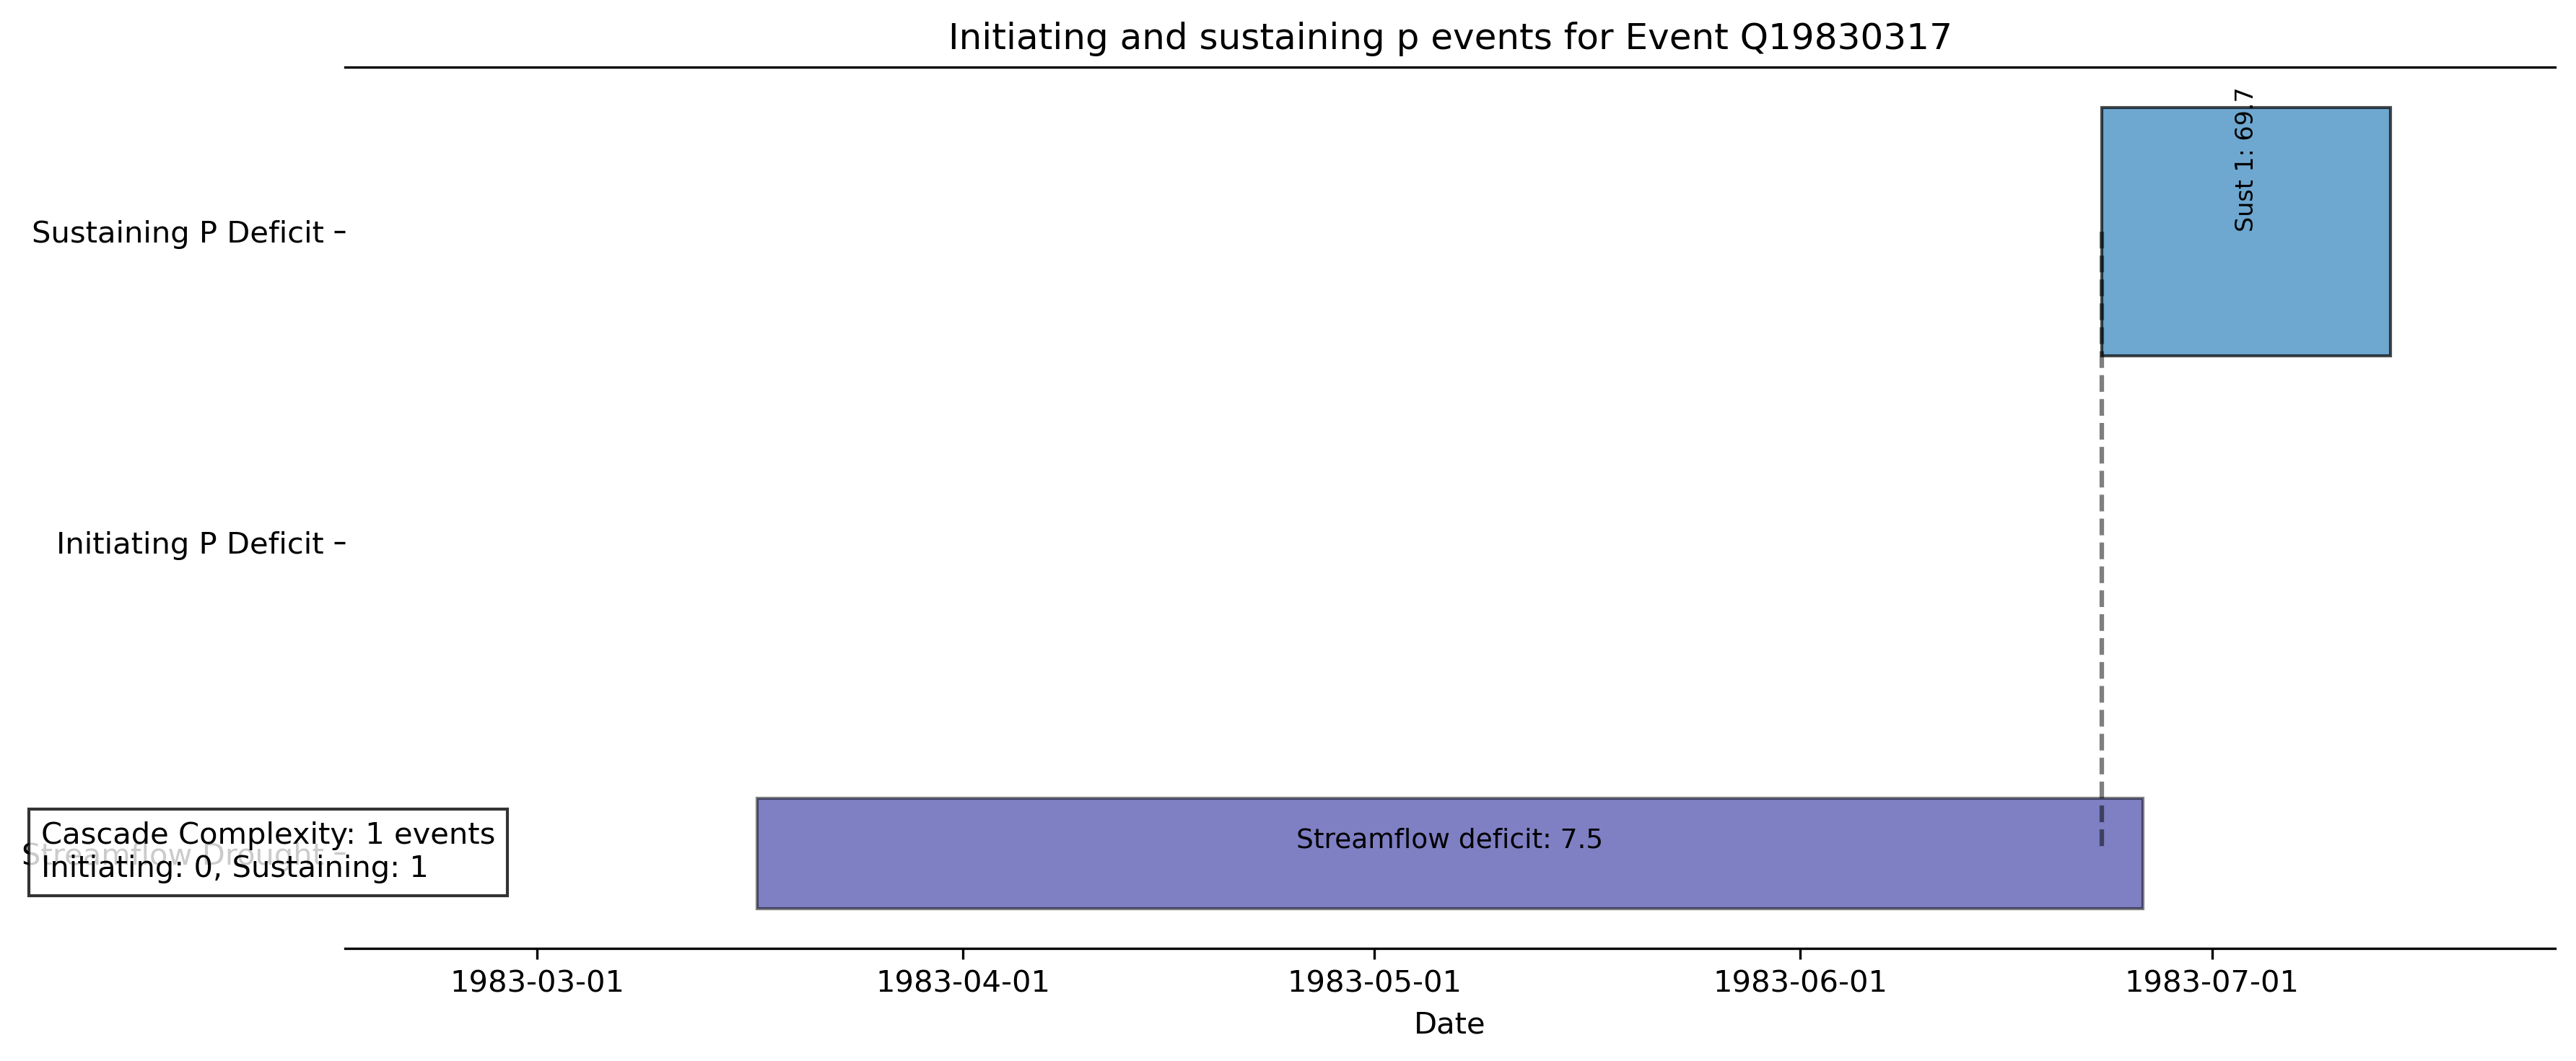

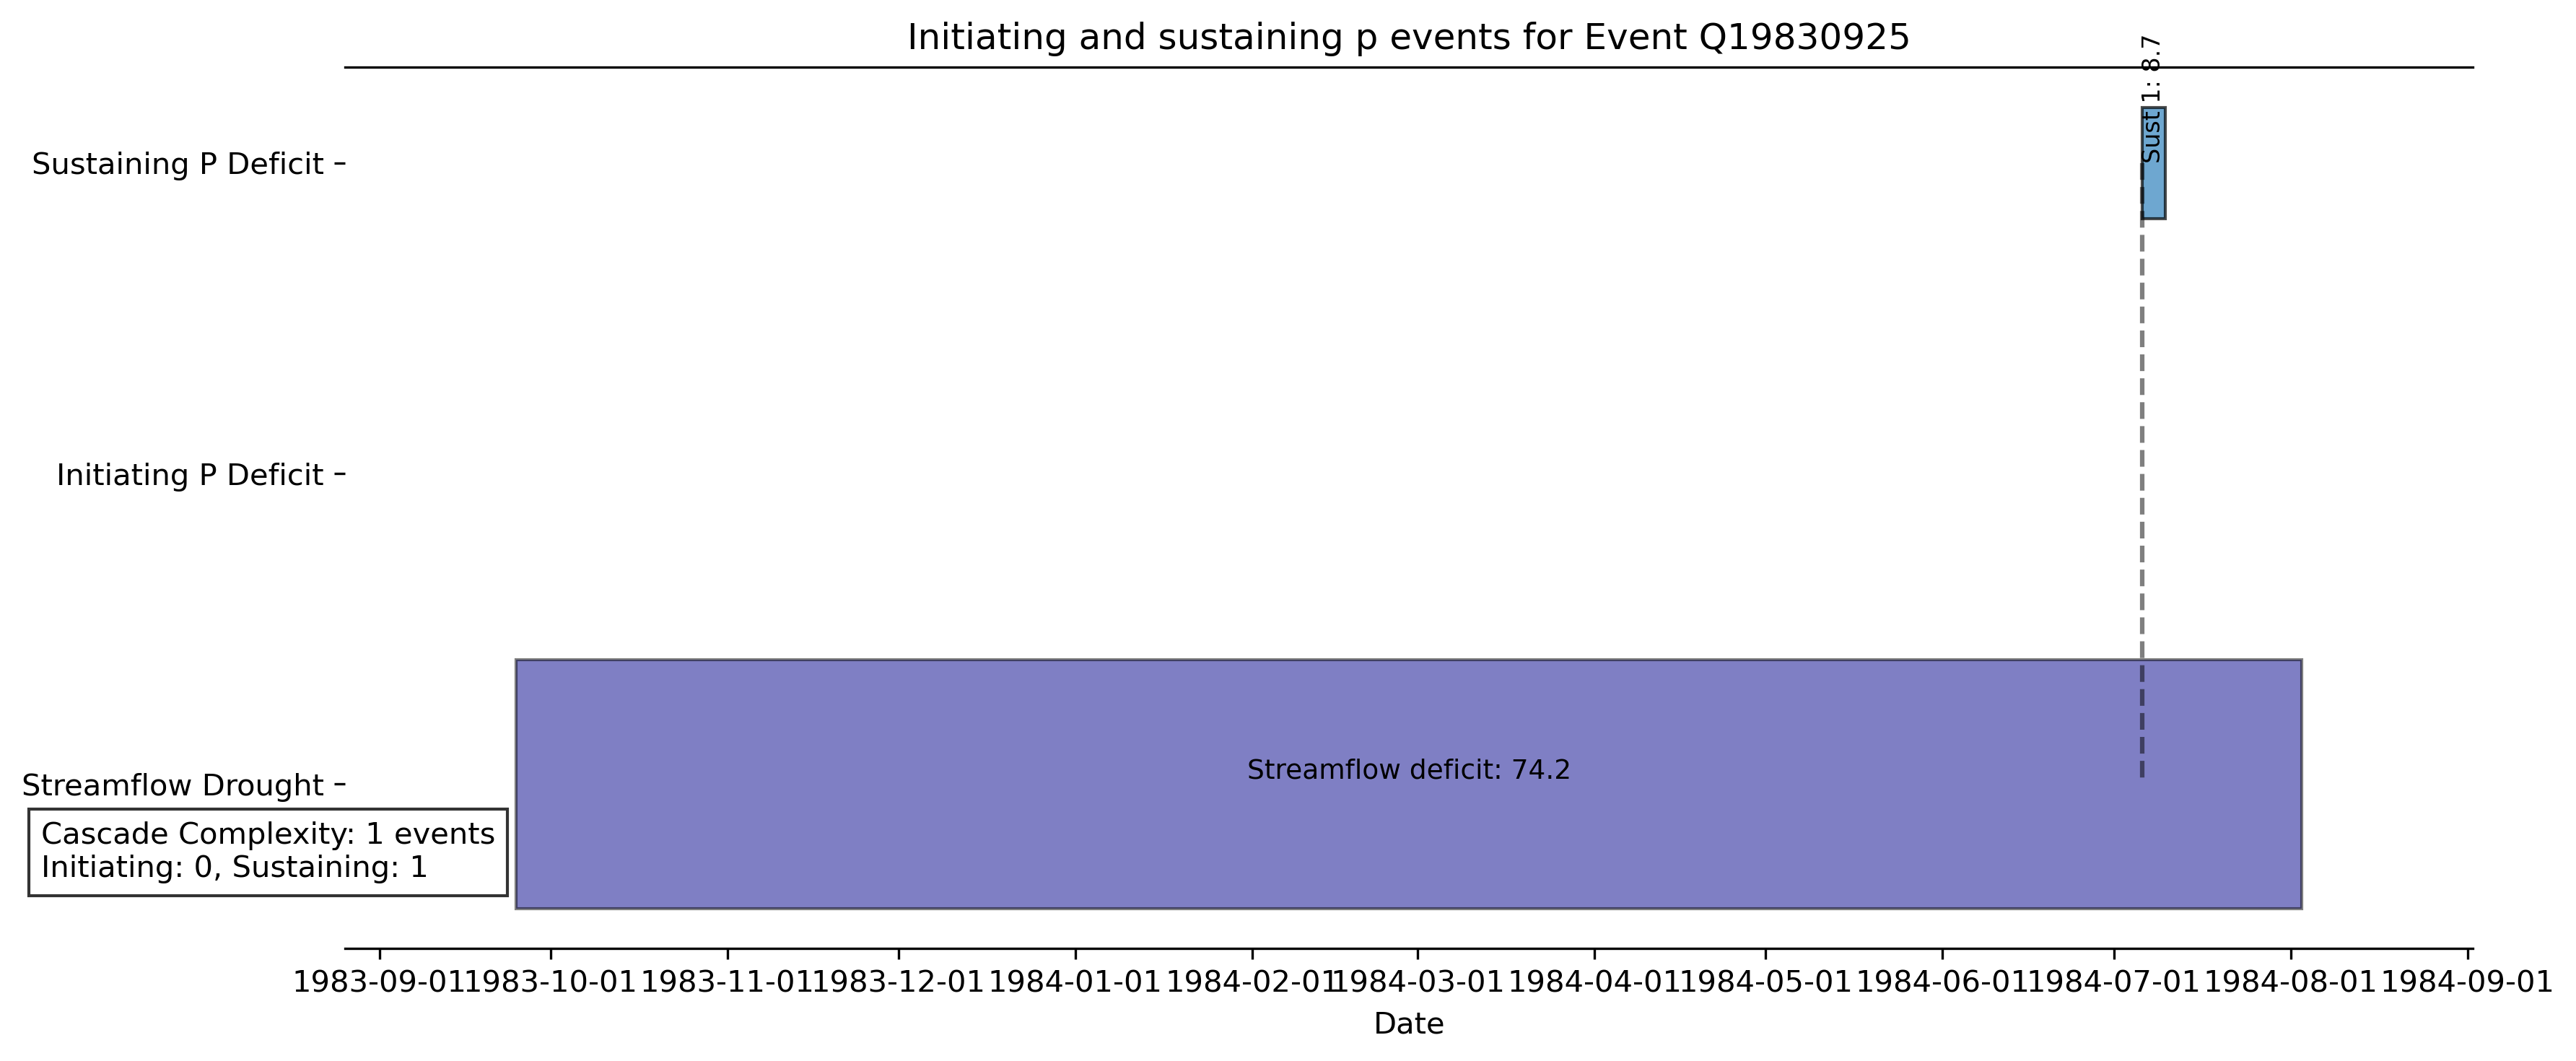

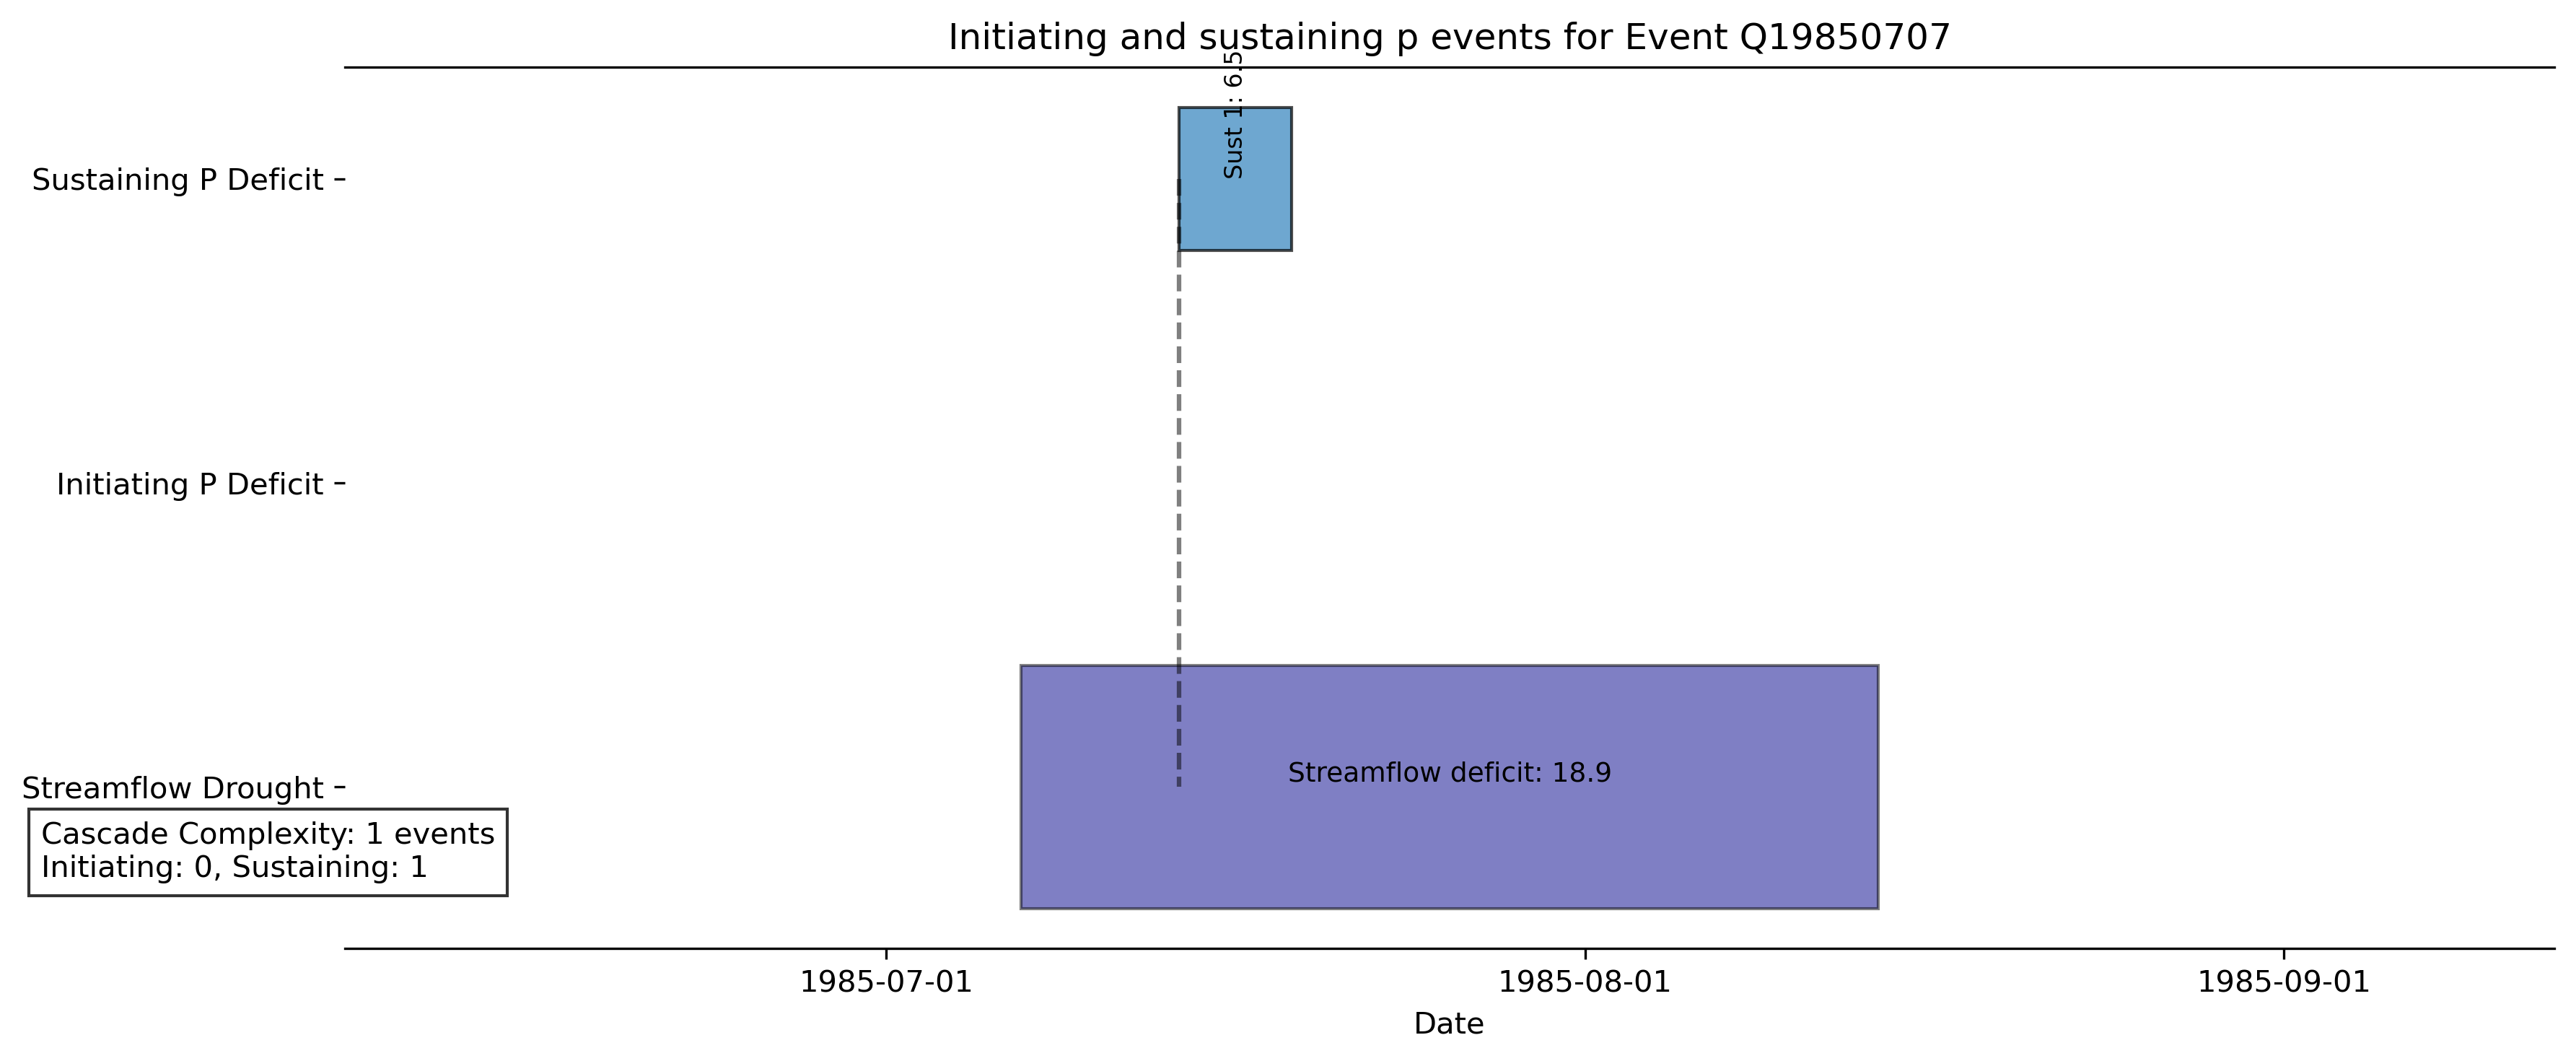

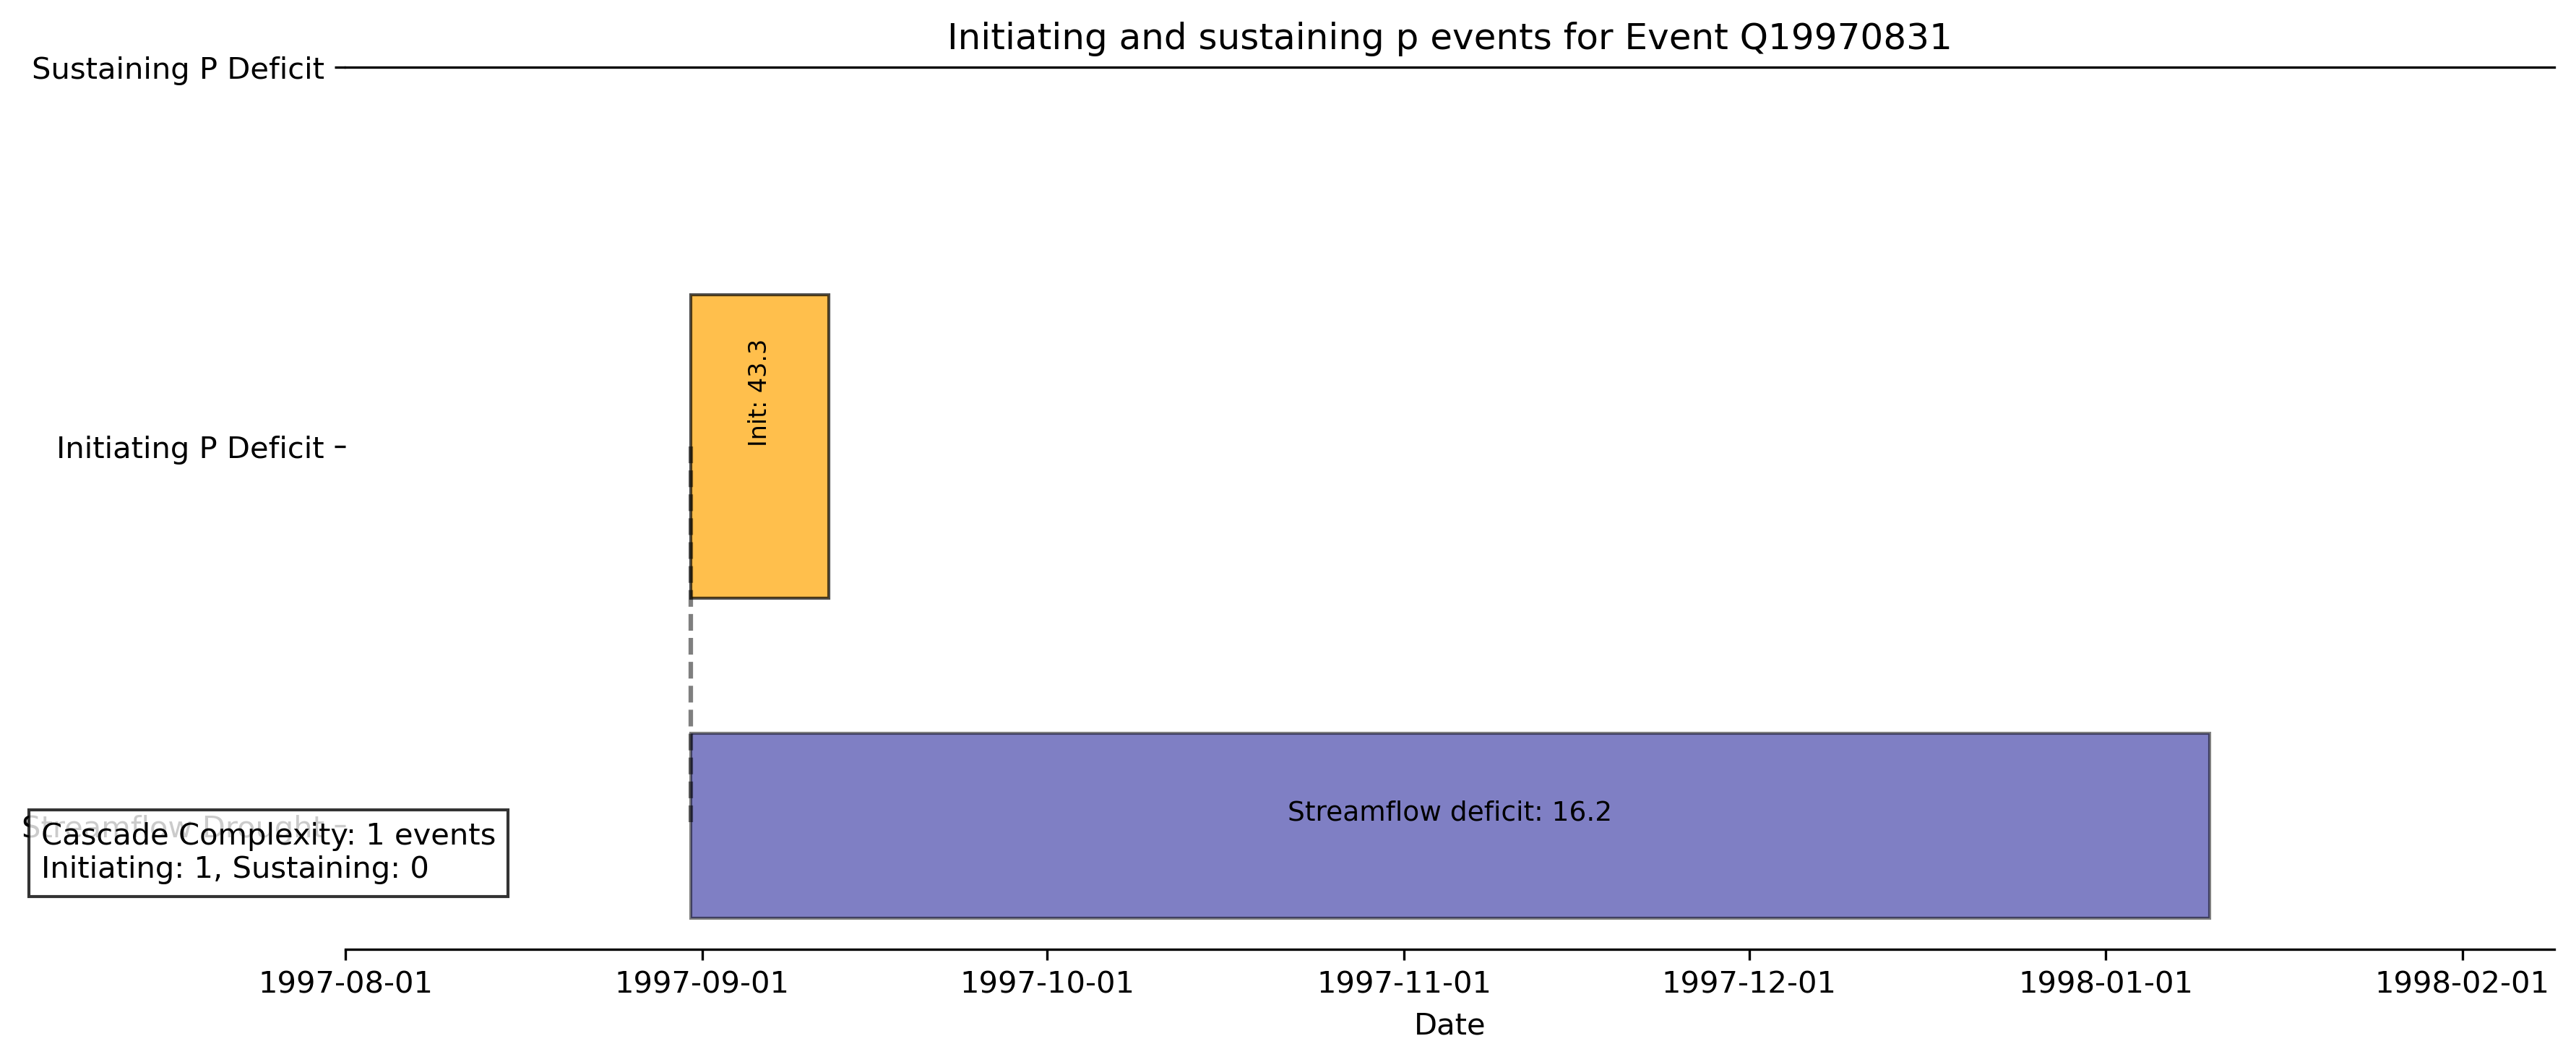

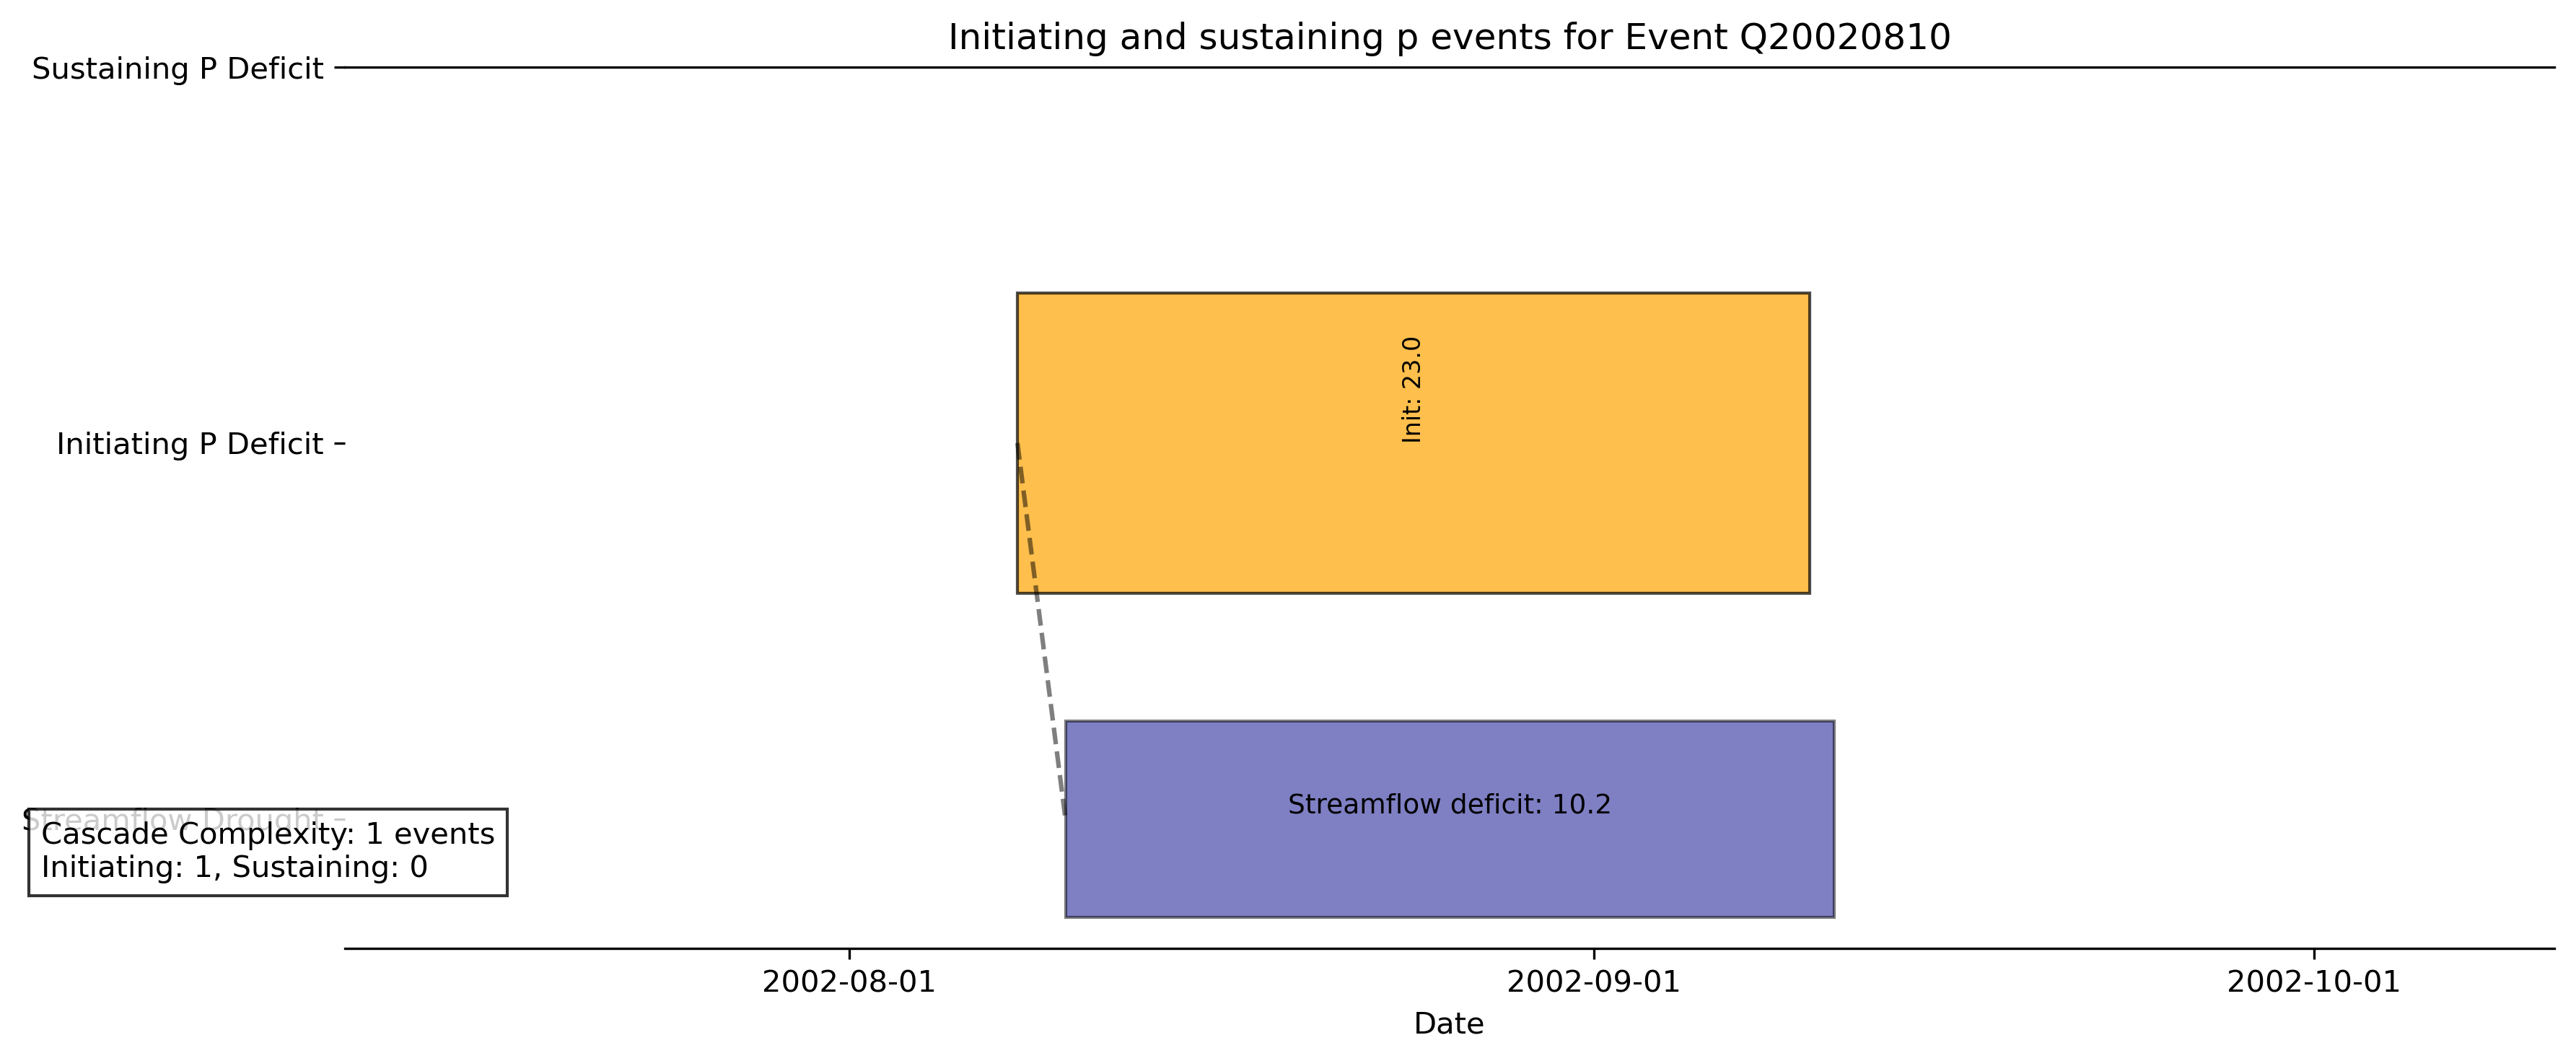

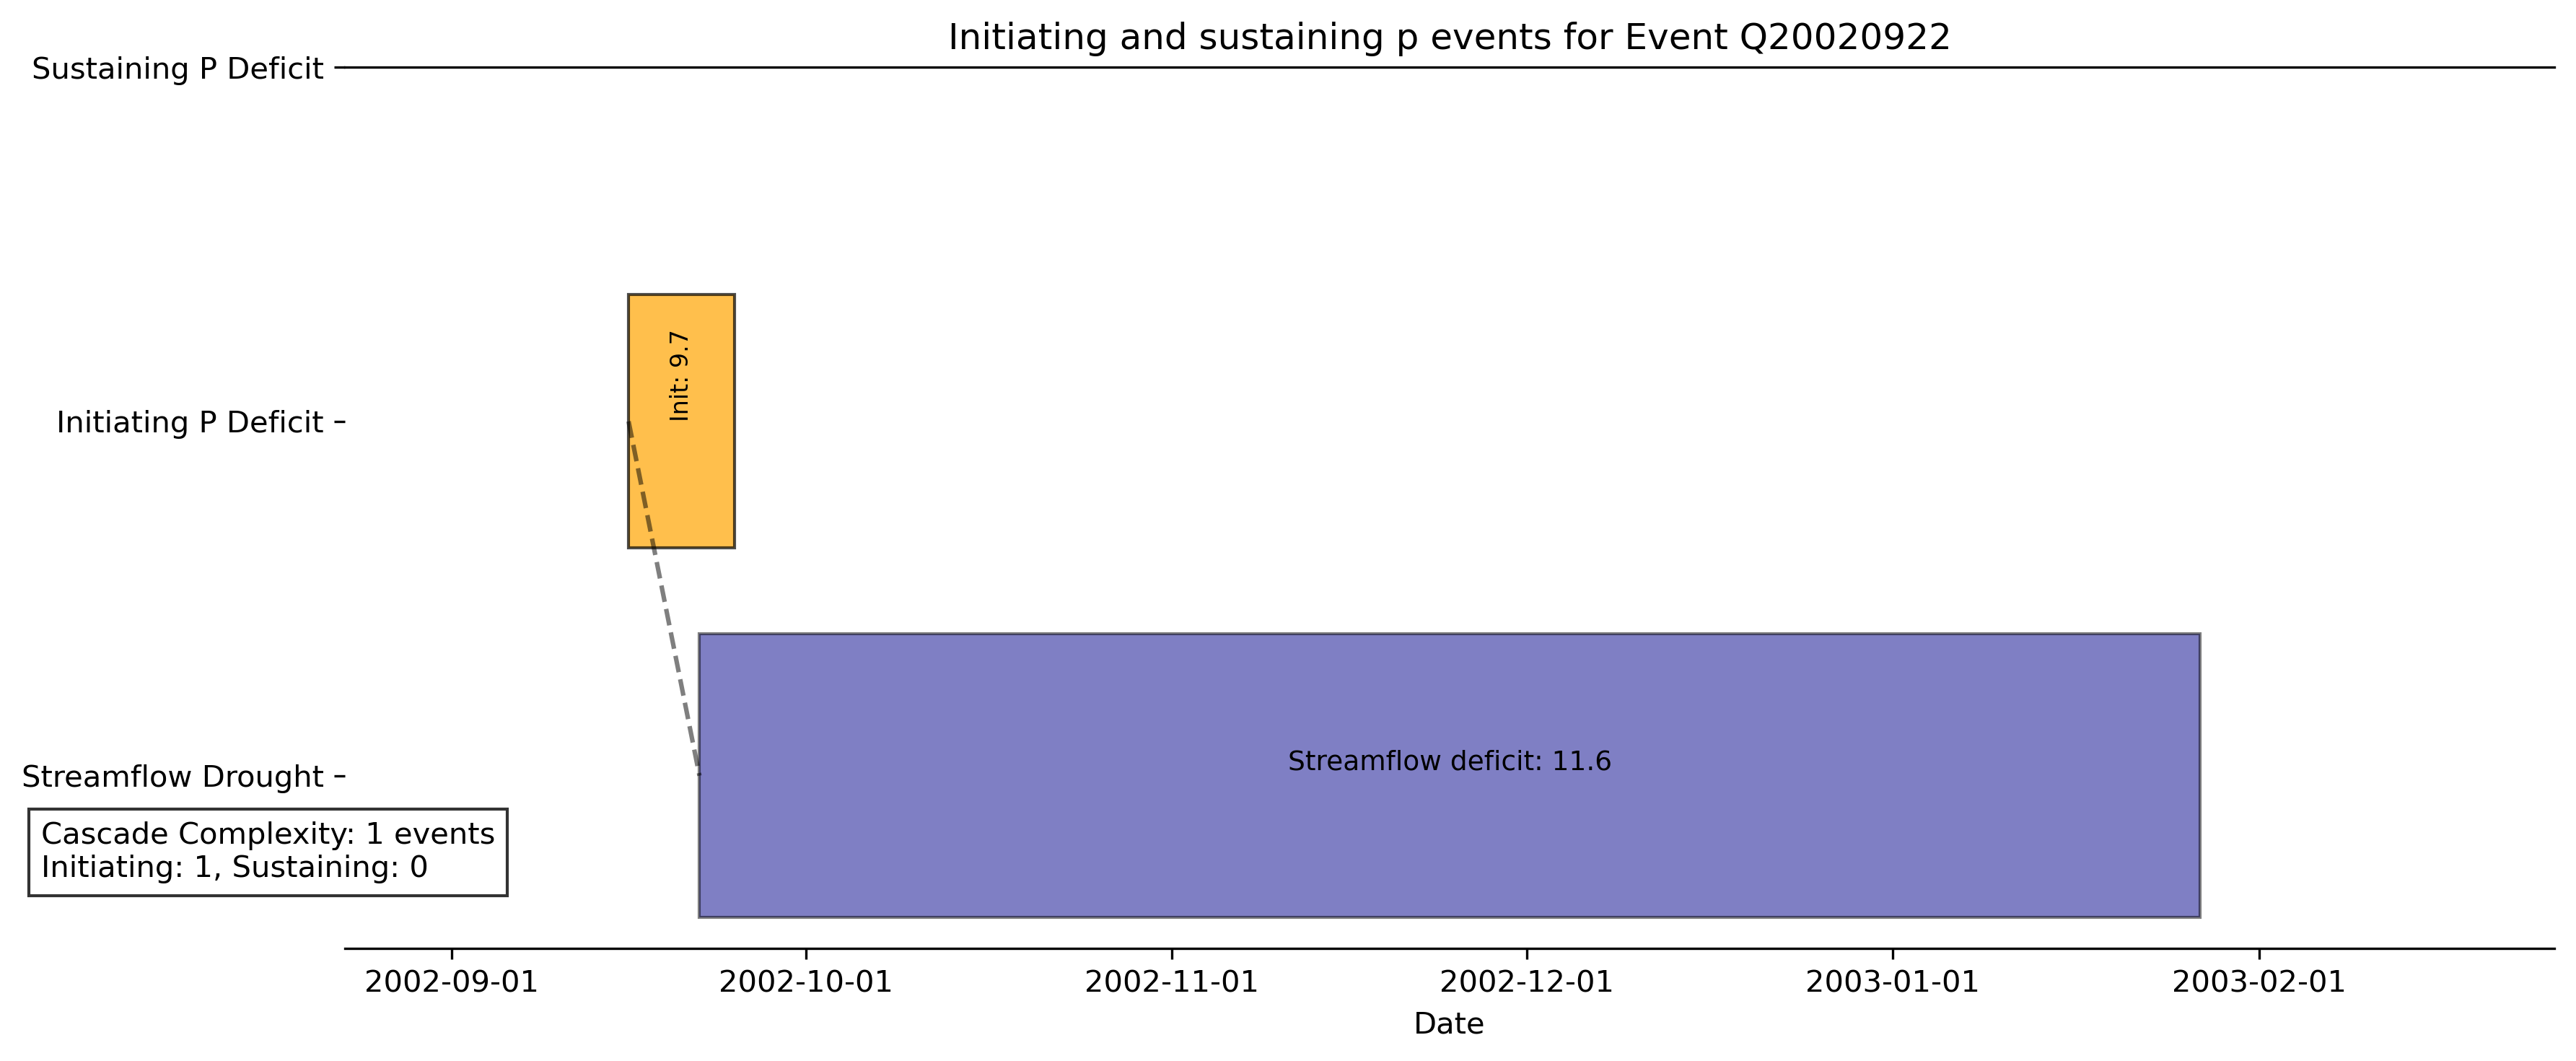

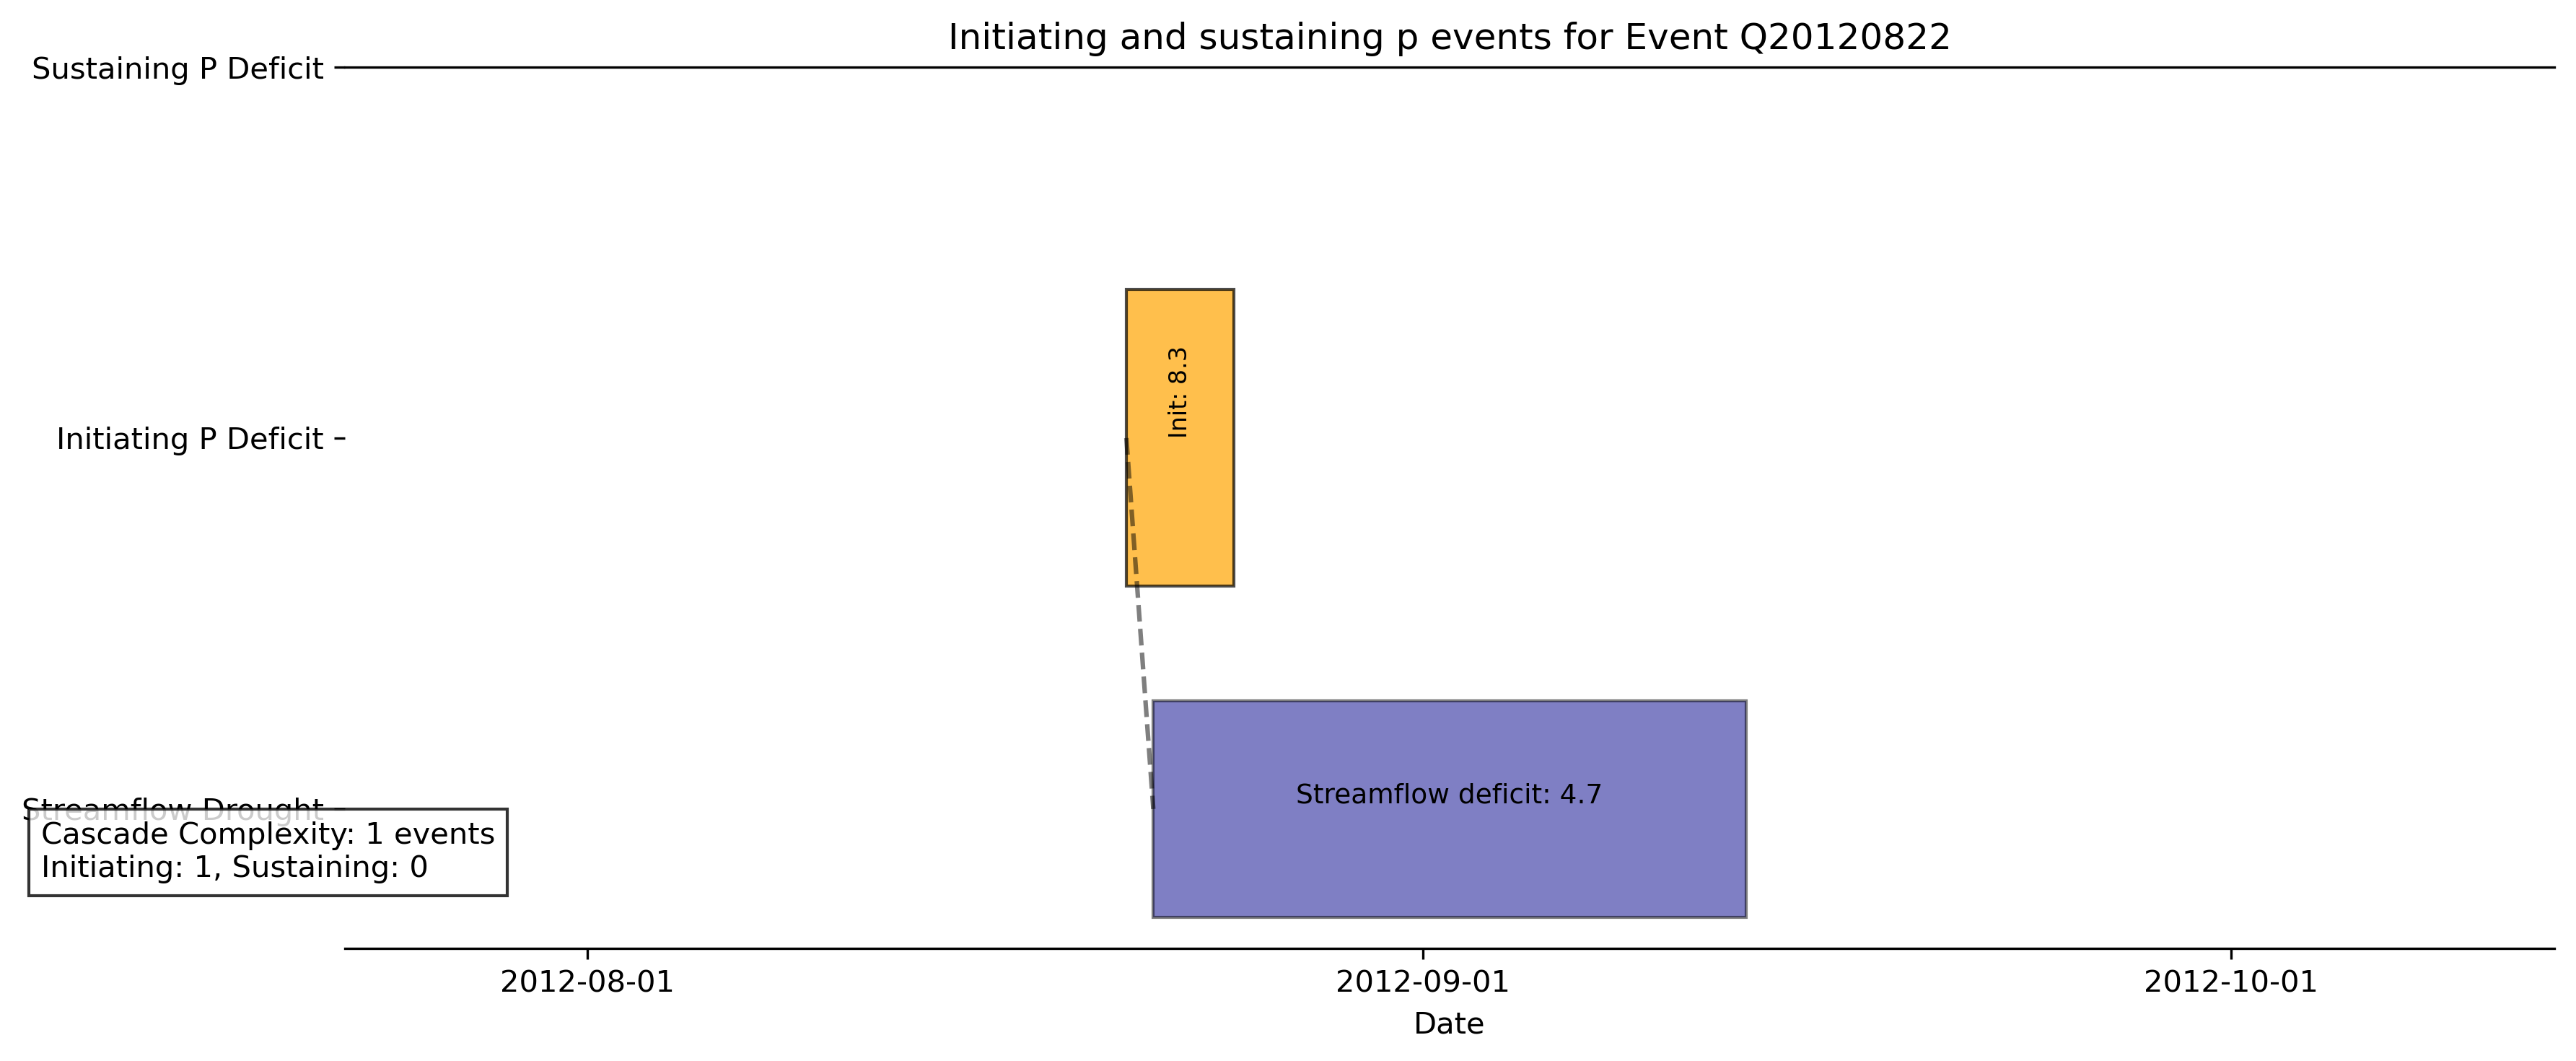

In [24]:
for i in range(0,len(cascade_summary_df)):
    fig = plot_simplified_drought_cascade(relationships_df, cascade_summary_df.iloc[i,0])

In [25]:
# Separate by relationship type
initiating_relationships = relationships_df[relationships_df['relationship_type'] == 'initiating']
sustaining_relationships = relationships_df[relationships_df['relationship_type'] == 'sustaining']

# Standard propagation metrics (from initiating relationships)
init_metrics = {
    'P_to_Q_Likelihood': len(initiating_relationships) / total_p_events if total_p_events > 0 else 0,
    'Mean_Initial_Lag_Days': initiating_relationships['lag'].mean() if not initiating_relationships.empty else None,
    'Median_Initial_Lag_Days': initiating_relationships['lag'].median() if not initiating_relationships.empty else None,
}

# New sustaining metrics
sustaining_metrics = {
    'Avg_Sustaining_P_Events_Per_Q': len(sustaining_relationships) / total_q_events if total_q_events > 0 else 0,
    'Mean_Overlap_Ratio': sustaining_relationships['overlap_ratio'].mean() if not sustaining_relationships.empty else None,
    'Q_Events_With_Sustaining_P': sustaining_relationships['event_id'].nunique() / total_q_events if total_q_events > 0 else 0,
}

# Combined metrics
lsu_metrics = {**init_metrics, **sustaining_metrics}

# Calculate lengthening metric - how much P droughts extend Q droughts
if not sustaining_relationships.empty:
    # Group by Q event and find the latest ending P drought
    q_extension = sustaining_relationships.groupby('event_id').agg({
        'end_date_precip': 'max',
        'end_date_streamflow': 'first'
    })
    
    # Calculate how much P extends beyond Q end
    q_extension['extension_days'] = (q_extension['end_date_precip'] - q_extension['end_date_streamflow']).dt.days
    
    # Only positive extensions (P ends after Q)
    q_extension = q_extension[q_extension['extension_days'] > 0]
    
    lsu_metrics['Mean_Q_Extension_Days'] = q_extension['extension_days'].mean() if not q_extension.empty else 0
    lsu_metrics['Q_Events_Extended_By_P'] = len(q_extension) / total_q_events if total_q_events > 0 else 0

In [26]:
current_vars = set(locals().keys())

In [27]:
user_defined_vars = current_vars - initial_vars

# Step 5: Print or use the list of user-defined variables
print("User-defined variables:", user_defined_vars)

User-defined variables: {'_i7', 'total_p_events', 'classify_relationship', 'plot_simplified_drought_cascade', 'flow_data_subset', 'channel_data', 'aligned_p_duration', 'aligned_df', 'TMIN_DAYS', '_i24', '_20', 'filtered_postp_data', 'filtered_postp_channel_data', 'initial_vars', 'identify_drought_relationships', 'lsu_var_to_analyze', 'precip_df', 'relationship_counts', 'mean_severity_ratio', 'PERCENTILES_TO_ANALYZE', 'N_DAYS_TO_ANALYZE', 'identify_drought_cascades', 'lsu_file_path', 'create_daily_threshold_array', '_i10', 'max_lag_days', 'sustaining_metrics', '_i15', 'flow_threshold_df', 'total_q_events', '_i17', 'precip_deficits', 'calculate_percentile_thresholds', 'mean_duration_days', '_i23', 'flow_deficits', 'data_channel', '_i9', 'drought_threshold_key', 'flow_percentile_dfs', '_i22', 'precip_data_subset', 'flow_daily_thresholds', 'aggregated_p', 'sustaining_relationships', 'complex_events', 'all_relationships', '_7', 'ml_df_enhanced', 'i', 'precip_daily_thresholds', 'prepare_ml_f

In [28]:
variables_to_keep = ['lsu_numbers', 'channel_numbers', 'lsu_id', 'channel_id', 'counter', 'get_next_pair']
vars_to_delete = user_defined_vars - set(variables_to_keep)

In [29]:
for var in vars_to_delete:
    del locals()[var]

# Run garbage collection to free up memory
gc.collect()  
remaining_vars = set(locals().keys())
print("Remaining variables:", remaining_vars)

Remaining variables: {'In', 'counter', 'vars_to_delete', '_dh', '__name__', 'Out', 'sns', 'get_next_pair', 'var', '_oh', 'exit', 'get_ipython', 'os', 'channel_numbers', '__builtin__', '_i28', '_i1', 'user_defined_vars', 'lsu_id', '_i2', '__session__', '_', 'channel_id', '_i27', 'current_vars', 'plt', 'open', '_iii', 'warnings', 'variables_to_keep', '__', 'calendar', '___', '_i', '_ih', '_i29', '__spec__', 'datetime', '__builtins__', 'pd', 'gc', '__package__', '__doc__', 'np', '__loader__', 'timedelta', 'lsu_numbers', 'quit', '_ii'}
